In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt    
import os 
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator
from definitions import *
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
matplotlib.rcParams["figure.dpi"] = 150
from particle import PDGID
from utils import delphesRootToPixelAvTrackList as utils                           

In [3]:
def cutData(truth, recon, data, symbol, val, data2=None, symbol2=None, val2=None):
    if symbol == '>':
        cut = truth[data]>val
    elif symbol == '<':
        cut = truth[data]<val
    elif symbol == '>=':
        cut = truth[data]>=val
    elif symbol == '<=':
        cut = truth[data]<=val
    elif symbol == '==':
        cut = truth[data]==val
    
    if data2 != None:
        if symbol2 == '>':
            cut2 = truth[data2]>val2
        elif symbol2 == '<':
            cut2 = truth[data2]<val2
        elif symbol2 == '>=':
            cut2 = truth[data2]>=val2
        elif symbol2 == '<=':
            cut2 = truth[data2]<=val2
        elif symbol2 == '==':
            cut2 = truth[data2]==val2
        cut = cut & cut2

    truthCut = truth[cut] #.reset_index(inplace=True)
    reconCut = recon[cut] #.reset_index(inplace=True)

    truthCut.reset_index(inplace=True, drop=True)
    reconCut.reset_index(inplace=True, drop=True)

    clustersCut = reconCut.to_numpy().reshape(reconCut.shape[0],13,21)
    
    return truthCut, reconCut, clustersCut

def getYProfiles(clusters):
    profiles = np.sum(clusters, axis = 2)
    #totalCharge = np.sum(profiles, axis = 1, keepdims=True)
    return profiles

def getAverageYProfile(clusters):
    profiles=getYProfiles(clusters)
    return np.mean(profiles, axis=0)

def getXProfiles(clusters):
    profiles = np.sum(clusters, axis = 1)
    #totalCharge = np.sum(profiles, axis = 1, keepdims=True)
    return profiles

def getAverageXProfile(clusters):
    profiles=getXProfiles(clusters)
    return np.mean(profiles, axis=0)

def getClusterYSizes(clusters):
    profiles=getYProfiles(clusters)
    bool_arr = profiles != 0
    return np.sum(bool_arr, axis = 1)

def getAverageClusterYSize(clusters):
    clusterSizes = getClusterYSizes(clusters)
    return np.mean(clusterSizes)

def getClusterXSizes(clusters):
    profiles=getXProfiles(clusters)
    bool_arr = profiles != 0
    return np.sum(bool_arr, axis = 1)

def getAverageClusterXSize(clusters):
    clusterSizes = getClusterXSizes(clusters)
    return np.mean(clusterSizes)

def GetMeanVectorY(clusters):
    clusterSizes = getAverageYProfile(clusters)
    return np.mean(clusterSizes)

def getCovarianceMatrixY(clusters):

    # Get the cluster size profile (non-zero pixels along axis 1 and 2 for each cluster)
    clusterProfiles = getYProfiles(clusters)

    # Compute the covariance matrix
    covariance_matrix = np.cov(clusterProfiles, rowvar=False)
    
    return covariance_matrix

# Lets Find the distance
from scipy.stats import chi2

def Mahalanobis_Distance(cov_matrix, mean_vector, random_vector):
    """
    Compute the Mahalanobis distance using the pseudoinverse for singular covariance matrices.

    Parameters:
        cov_matrix (numpy.ndarray): Covariance matrix of the distribution (shape: n x n).
        mean_vector (numpy.ndarray): Mean vector of the distribution (shape: n,).
        random_vector (numpy.ndarray): Input random vector (shape: n,).

    Returns:
        float: The Mahalanobis distance.
    """
    # Convert inputs to numpy arrays if they are not already
    cov_matrix = np.asarray(cov_matrix)
    mean_vector = np.asarray(mean_vector)
    random_vector = np.asarray(random_vector)

    # Ensure the dimensions match
    if mean_vector.shape[0] != random_vector.shape[0]:
        raise ValueError("Mean vector and random vector dimensions do not match.")
    if cov_matrix.shape[0] != cov_matrix.shape[1] or cov_matrix.shape[0] != mean_vector.shape[0]:
        raise ValueError("Covariance matrix dimensions must match the length of the mean vector.")
    
    # Compute the difference vector
    diff = random_vector - mean_vector

    # Compute the pseudoinverse of the covariance matrix
    inv_cov_matrix = np.linalg.pinv(cov_matrix)
    
    # Compute Mahalanobis distance
    distance = np.sqrt(np.dot(np.dot(diff.T, inv_cov_matrix), diff))
    return distance

def Mahalanobis_Probability(D_M, d):
    """
    Compute the probability (p-value) that a vector belongs to a given distribution.

    Parameters:
        D_M (float): Mahalanobis distance.
        d (int): Degrees of freedom (dimensionality of the vector).

    Returns:
        float: Probability that the vector belongs to the distribution.
    """
    # Compute the squared Mahalanobis distance
    D_M_squared = D_M ** 2
    
    # Compute the cumulative distribution function (CDF) for chi-squared distribution
    chi2_cdf = chi2.cdf(D_M_squared, df=d)
    
    # Compute the probability (p-value)
    p_value = 1 - chi2_cdf
    
    return p_value

In [4]:
datadir = '/home/youeric/PixelSim/PixSim/'
flp = 0

In [5]:
truthbib = pd.DataFrame()
recon2Dbib = pd.DataFrame()
truthsig = pd.DataFrame()
recon2Dsig = pd.DataFrame()

for file in os.listdir(datadir):
    if "labels" in file:
        if "bib" in file: 
            truthbib = pd.concat([truthbib,pd.read_parquet(f"{datadir}{file}")])
            file = file.replace("labels","recon2D")
            recon2Dbib = pd.concat([recon2Dbib,pd.read_parquet(f"{datadir}{file}")])
        elif "sig" in file: 
            truthsig = pd.concat([truthsig,pd.read_parquet(f"{datadir}{file}")])
            file = file.replace("labels","recon2D")
            recon2Dsig = pd.concat([recon2Dsig,pd.read_parquet(f"{datadir}{file}")])
            
clustersSig = recon2Dsig.to_numpy().reshape(recon2Dsig.shape[0],13,21)
clustersBib = recon2Dbib.to_numpy().reshape(recon2Dbib.shape[0],13,21)

In [6]:
# Seperate into out by ylocal

TruthsigLow, recon2DsigLow, clusterssigLow = cutData(truthsig, recon2Dsig, 'y-local', '<', -2)
TruthsigMid, recon2DsigMid, clusterssigMid = cutData(truthsig, recon2Dsig, 'y-local', '>', 0, 'y-local', '<', 2)
TruthsigHigh, recon2DsigHigh, clusterssigHigh = cutData(truthsig, recon2Dsig, 'y-local', '>', 6)

profilesigLow = getAverageYProfile(clusterssigLow)
profilesigMid = getAverageYProfile(clusterssigMid)
profilesigHigh = getAverageYProfile(clusterssigHigh)

TruthbibLow, recon2DbibLow, clustersbibLow = cutData(truthbib, recon2Dbib, 'y-local', '<', -2)
TruthbibMid, recon2DbibMid, clustersbibMid = cutData(truthbib, recon2Dbib, 'y-local', '>', 0, 'y-local', '<', 2)
TruthbibHigh, recon2DbibHigh, clustersbibHigh = cutData(truthbib, recon2Dbib, 'y-local', '>', 6)

profilebibLow = getAverageYProfile(clustersbibLow)
profilebibMid = getAverageYProfile(clustersbibMid)
profilebibHigh = getAverageYProfile(clustersbibHigh)

In [7]:
def remove_outliers_by_iqr(clusters):
    # Compute the Y profiles
    y_profiles = getYProfiles(clusters)
    
    # Calculate IQR for each element (column)
    Q1 = np.percentile(y_profiles, 25, axis=0)  # 25th percentile (Q1)
    Q3 = np.percentile(y_profiles, 75, axis=0)  # 75th percentile (Q3)
    IQR = Q3 - Q1  # Interquartile Range
    
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify clusters that are within bounds for all elements
    within_bounds = np.all((y_profiles >= lower_bound) & (y_profiles <= upper_bound), axis=1)
    
    # Filter out outlier clusters
    filtered_clusters = clusters[within_bounds]
    
    return filtered_clusters

# Apply the IQR outlier removal to each cluster dataset
filtered_clusterssigLow = remove_outliers_by_iqr(clusterssigLow)
filtered_clusterssigMid = remove_outliers_by_iqr(clusterssigMid)
filtered_clusterssigHigh = remove_outliers_by_iqr(clusterssigHigh)

filtered_profilesigLow = getAverageYProfile(filtered_clusterssigLow)
filtered_profilesigMid = getAverageYProfile(filtered_clusterssigMid)
filtered_profilesigHigh = getAverageYProfile(filtered_clusterssigHigh)

# Print the results
print(f"Original clusterssigLow shape: {clusterssigLow.shape}, Filtered: {filtered_clusterssigLow.shape}")
print(f"Original clusterssigMid shape: {clusterssigMid.shape}, Filtered: {filtered_clusterssigMid.shape}")
print(f"Original clusterssigHigh shape: {clusterssigHigh.shape}, Filtered: {filtered_clusterssigHigh.shape}")

Original clusterssigLow shape: (7187, 13, 21), Filtered: (3997, 13, 21)
Original clusterssigMid shape: (6032, 13, 21), Filtered: (3224, 13, 21)
Original clusterssigHigh shape: (7384, 13, 21), Filtered: (4627, 13, 21)


In [8]:
# Apply the IQR outlier removal to each cluster dataset for bib particles
filtered_clustersbibLow = remove_outliers_by_iqr(clustersbibLow)
filtered_clustersbibMid = remove_outliers_by_iqr(clustersbibMid)
filtered_clustersbibHigh = remove_outliers_by_iqr(clustersbibHigh)

# Compute the mean profiles for the filtered bib clusters
filtered_profilebibLow = getAverageYProfile(filtered_clustersbibLow)
filtered_profilebibMid = getAverageYProfile(filtered_clustersbibMid)
filtered_profilebibHigh = getAverageYProfile(filtered_clustersbibHigh)

# Print the results
print(f"Original clustersbibLow shape: {clustersbibLow.shape}, Filtered: {filtered_clustersbibLow.shape}")
print(f"Original clustersbibMid shape: {clustersbibMid.shape}, Filtered: {filtered_clustersbibMid.shape}")
print(f"Original clustersbibHigh shape: {clustersbibHigh.shape}, Filtered: {filtered_clustersbibHigh.shape}")

print("Filtered profilebibLow mean profile:", filtered_profilebibLow)
print("Filtered profilebibMid mean profile:", filtered_profilebibMid)
print("Filtered profilebibHigh mean profile:", filtered_profilebibHigh)

Original clustersbibLow shape: (6268, 13, 21), Filtered: (2685, 13, 21)
Original clustersbibMid shape: (5585, 13, 21), Filtered: (2364, 13, 21)
Original clustersbibHigh shape: (6328, 13, 21), Filtered: (2590, 13, 21)
Filtered profilebibLow mean profile: [0.00000000e+00 4.31314711e+01 3.38220857e+02 1.10942160e+03
 2.15275568e+03 2.45063687e+03 1.71955531e+03 7.38745996e+02
 1.68315829e+02 2.10837989e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Filtered profilebibMid mean profile: [0.00000000e+00 3.32538071e+01 2.88917090e+02 1.07716836e+03
 2.18893316e+03 2.55025508e+03 1.74694459e+03 6.73560914e+02
 1.41652707e+02 1.37225042e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Filtered profilebibHigh mean profile: [   0.           41.34324324  341.70540541 1130.42625483 2259.86023166
 2608.10926641 1712.4957529   658.53359073  159.4011583     5.4984556
    0.            0.            0.        ]


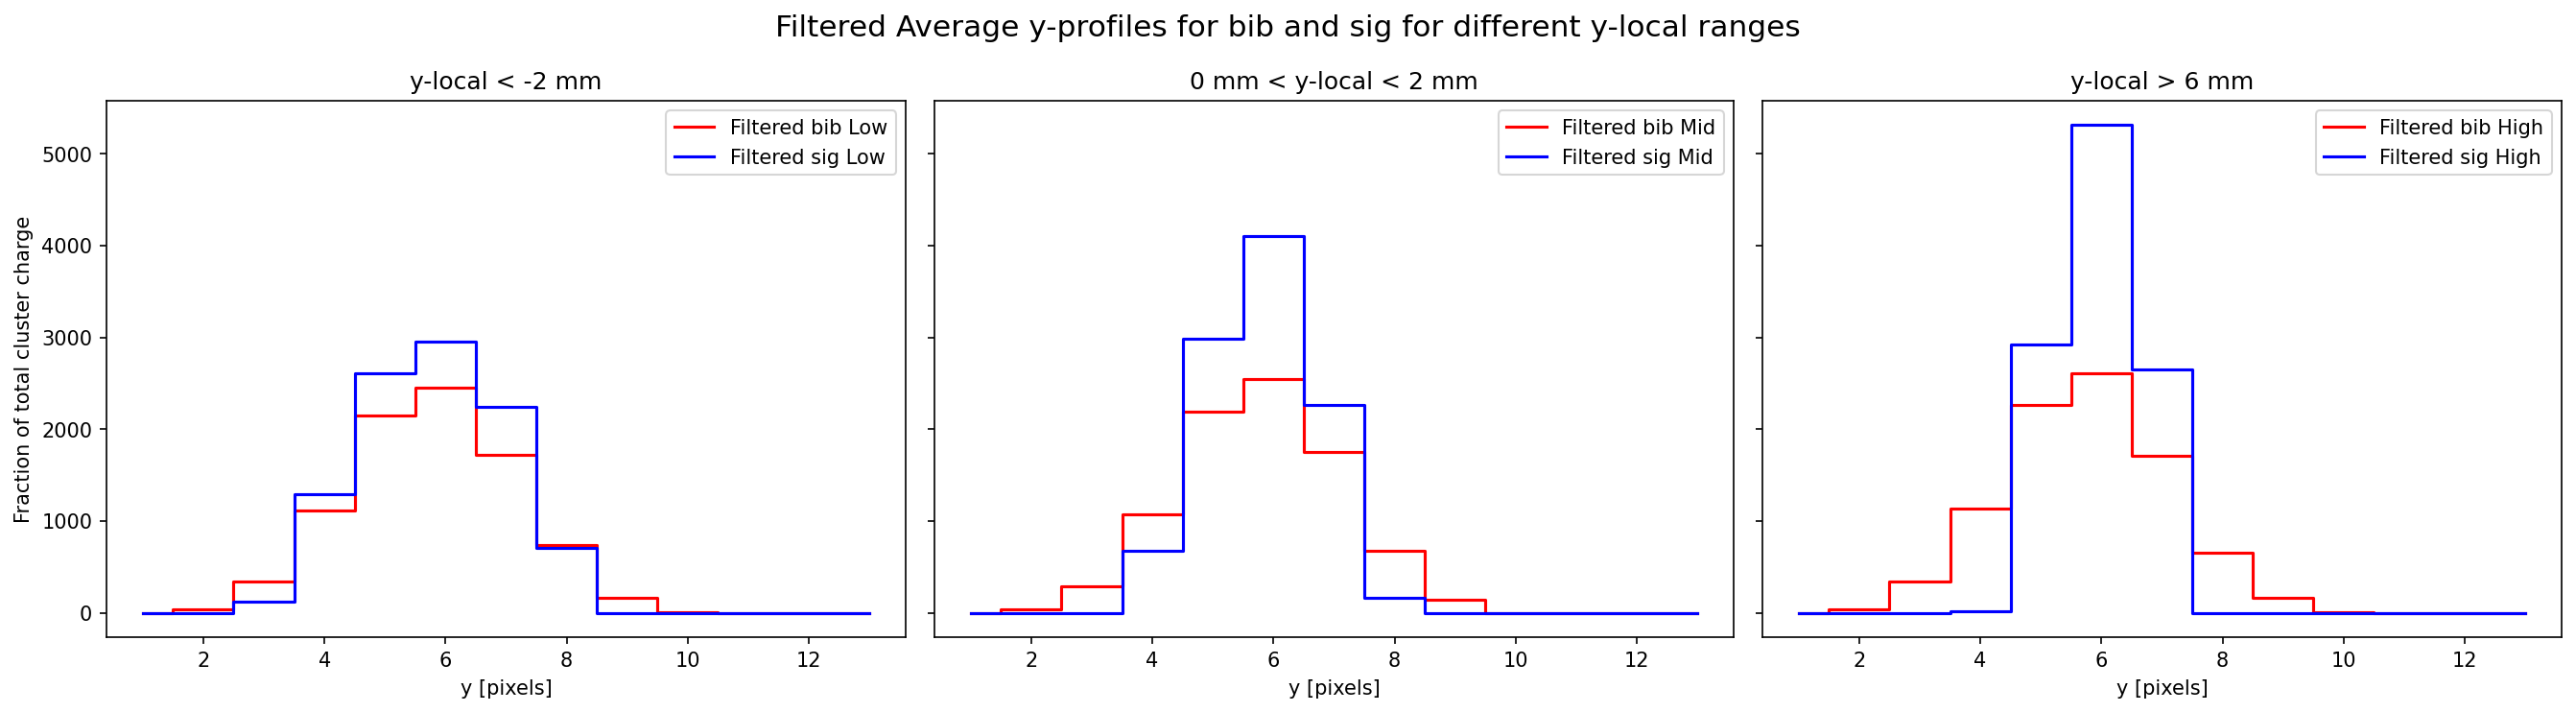

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Replace these with the actual filtered profile data
yaxis = np.arange(1, len(filtered_profilebibLow) + 1, 1)

# Plot
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18, 5))

# Plot for Low profiles
ax[0].step(yaxis, filtered_profilebibLow, where="mid", label="Filtered bib Low", c='r')
ax[0].step(yaxis, filtered_profilesigLow, where="mid", label="Filtered sig Low", c='b')
ax[0].legend()
ax[0].set_title("y-local < -2 mm")
ax[0].set_ylabel("Fraction of total cluster charge")
ax[0].set_xlabel("y [pixels]")

# Plot for Mid profiles
ax[1].step(yaxis, filtered_profilebibMid, where="mid", label="Filtered bib Mid", c='r')
ax[1].step(yaxis, filtered_profilesigMid, where="mid", label="Filtered sig Mid", c='b')
ax[1].legend()
ax[1].set_title("0 mm < y-local < 2 mm")
ax[1].set_xlabel("y [pixels]")

# Plot for High profiles
ax[2].step(yaxis, filtered_profilebibHigh, where="mid", label="Filtered bib High", c='r')
ax[2].step(yaxis, filtered_profilesigHigh, where="mid", label="Filtered sig High", c='b')
ax[2].legend()
ax[2].set_title("y-local > 6 mm")
ax[2].set_xlabel("y [pixels]")

# Add an overall title and layout adjustments
fig.suptitle('Filtered Average y-profiles for bib and sig for different y-local ranges', fontsize=15)
plt.tight_layout()
plt.show()


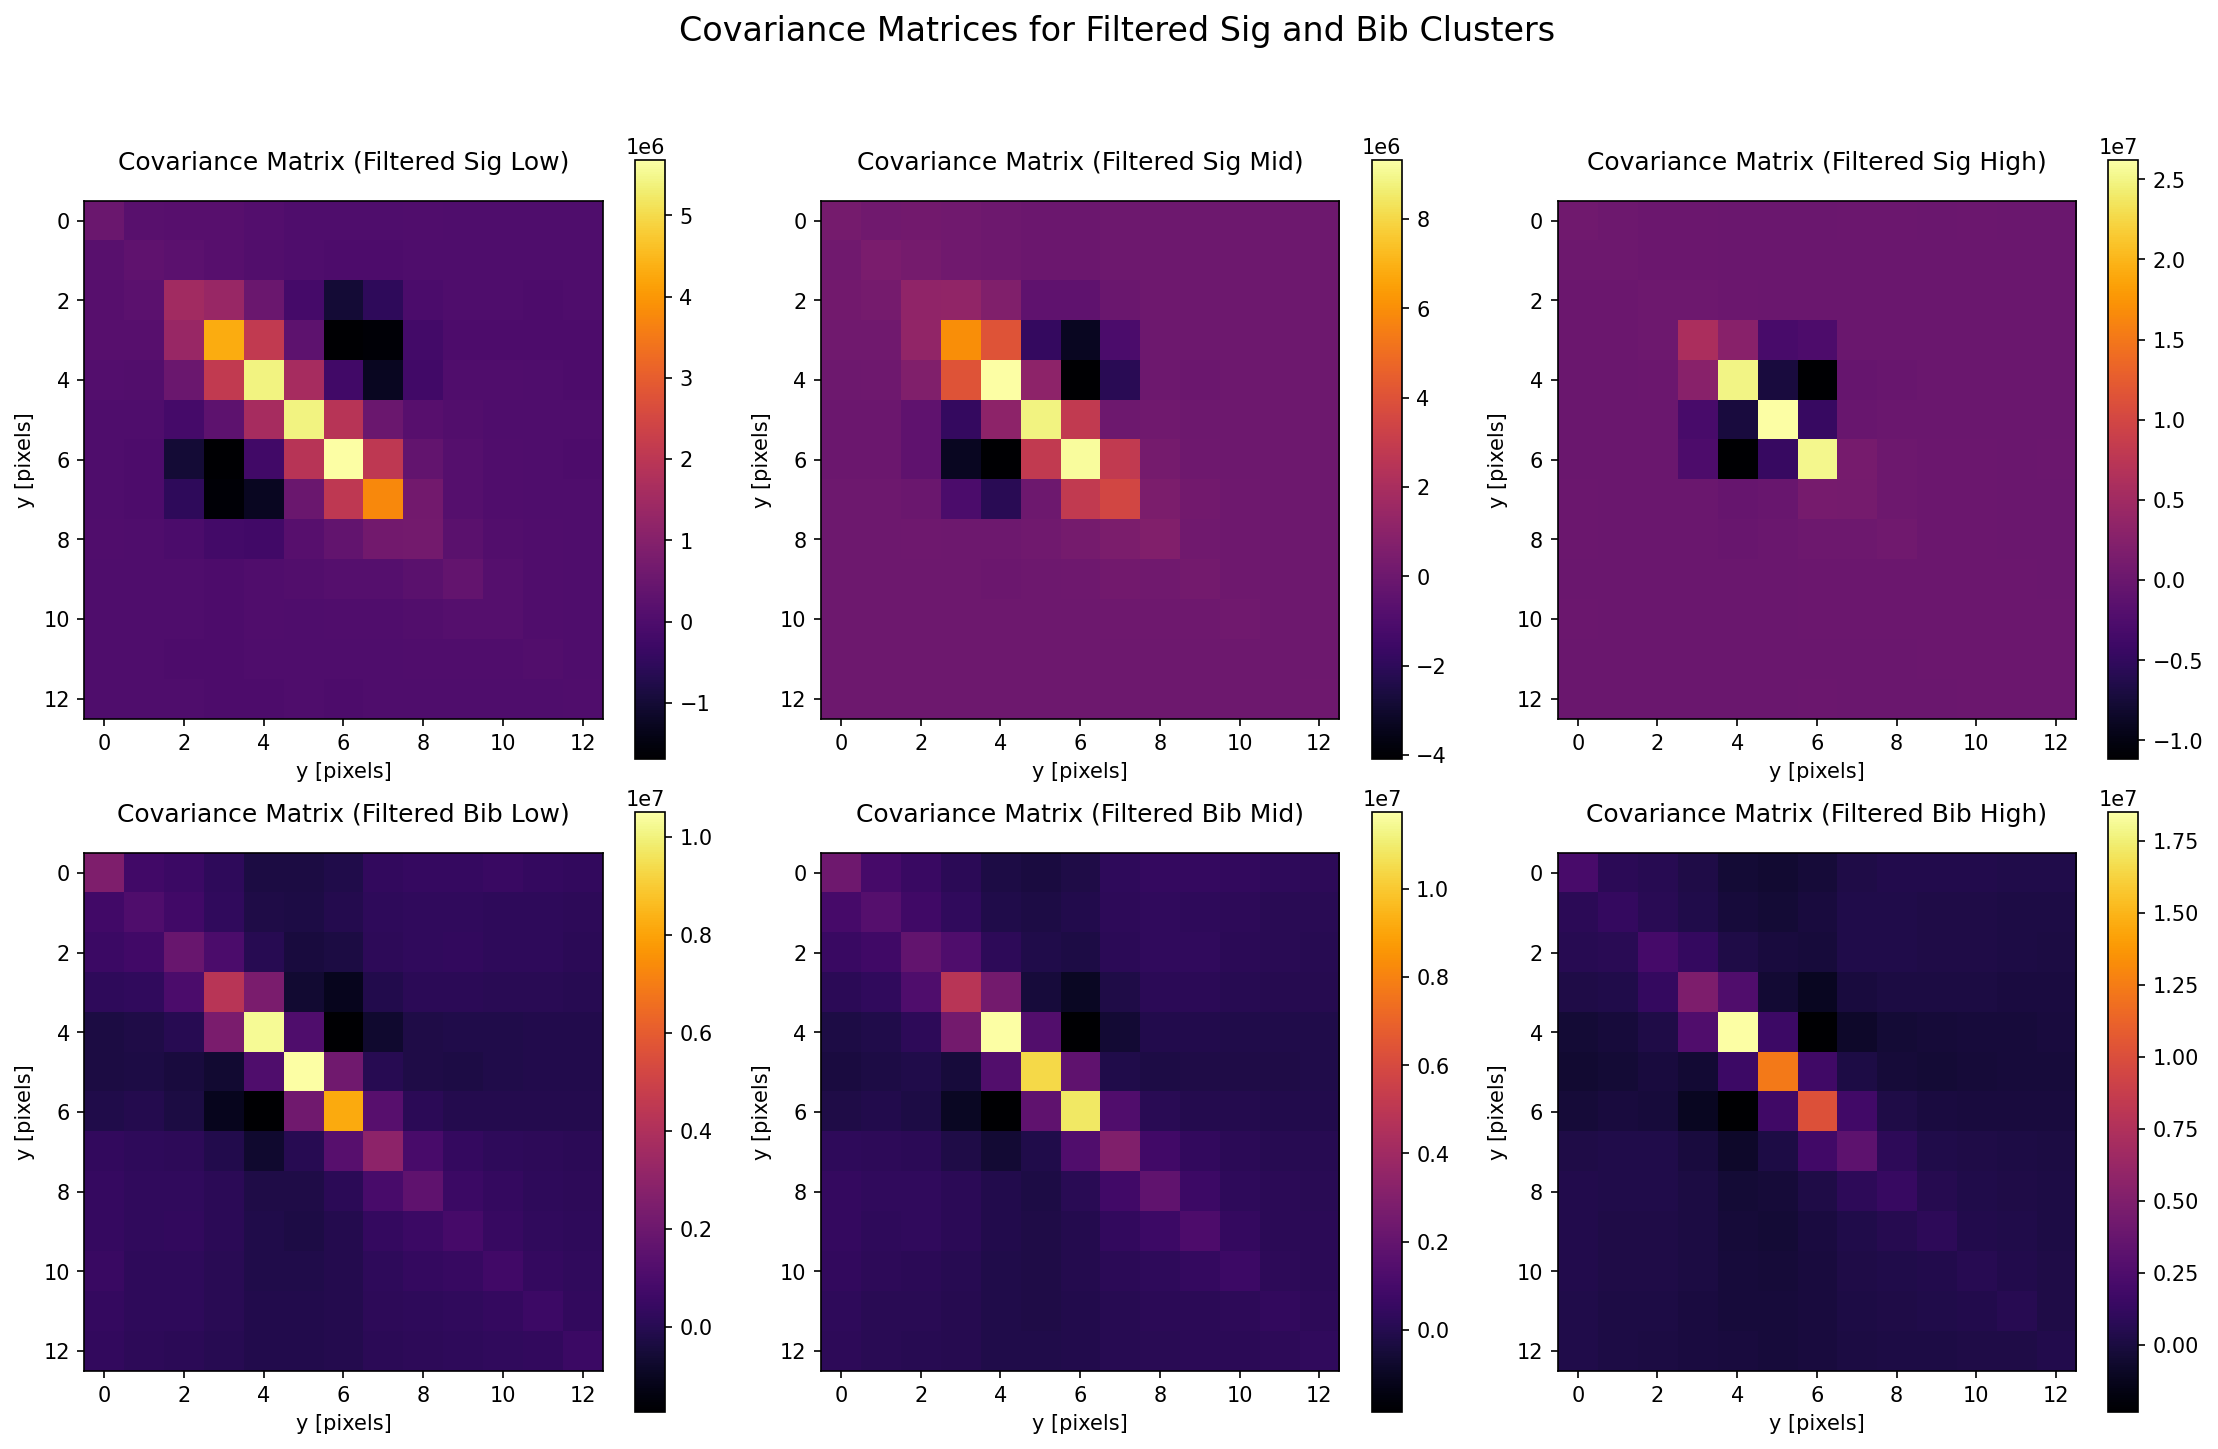

In [10]:
import matplotlib.pyplot as plt

# Replace these with the actual covariance matrix computation for the filtered data
covariance_matrix_sig_low_filtered = getCovarianceMatrixY(clusterssigLow)
covariance_matrix_sig_mid_filtered = getCovarianceMatrixY(clusterssigMid)
covariance_matrix_sig_high_filtered = getCovarianceMatrixY(clusterssigHigh)

covariance_matrix_bib_low_filtered = getCovarianceMatrixY(clustersbibLow)
covariance_matrix_bib_mid_filtered = getCovarianceMatrixY(clustersbibMid)
covariance_matrix_bib_high_filtered = getCovarianceMatrixY(clustersbibHigh)

# Plot Covariance Matrices for the filtered data
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Sig covariance matrices
im = axes[0, 0].imshow(covariance_matrix_sig_low_filtered, cmap='inferno')
axes[0, 0].set_title('Covariance Matrix (Filtered Sig Low)', pad=15)
axes[0, 0].set_xlabel('y [pixels]')
axes[0, 0].set_ylabel('y [pixels]')
plt.colorbar(im, ax=axes[0, 0])

im = axes[0, 1].imshow(covariance_matrix_sig_mid_filtered, cmap='inferno')
axes[0, 1].set_title('Covariance Matrix (Filtered Sig Mid)', pad=15)
axes[0, 1].set_xlabel('y [pixels]')
axes[0, 1].set_ylabel('y [pixels]')
plt.colorbar(im, ax=axes[0, 1])

im = axes[0, 2].imshow(covariance_matrix_sig_high_filtered, cmap='inferno')
axes[0, 2].set_title('Covariance Matrix (Filtered Sig High)', pad=15)
axes[0, 2].set_xlabel('y [pixels]')
axes[0, 2].set_ylabel('y [pixels]')
plt.colorbar(im, ax=axes[0, 2])

# Bib covariance matrices
im = axes[1, 0].imshow(covariance_matrix_bib_low_filtered, cmap='inferno')
axes[1, 0].set_title('Covariance Matrix (Filtered Bib Low)', pad=15)
axes[1, 0].set_xlabel('y [pixels]')
axes[1, 0].set_ylabel('y [pixels]')
plt.colorbar(im, ax=axes[1, 0])

im = axes[1, 1].imshow(covariance_matrix_bib_mid_filtered, cmap='inferno')
axes[1, 1].set_title('Covariance Matrix (Filtered Bib Mid)', pad=15)
axes[1, 1].set_xlabel('y [pixels]')
axes[1, 1].set_ylabel('y [pixels]')
plt.colorbar(im, ax=axes[1, 1])

im = axes[1, 2].imshow(covariance_matrix_bib_high_filtered, cmap='inferno')
axes[1, 2].set_title('Covariance Matrix (Filtered Bib High)', pad=15)
axes[1, 2].set_xlabel('y [pixels]')
axes[1, 2].set_ylabel('y [pixels]')
plt.colorbar(im, ax=axes[1, 2])

# Set overall title and adjust layout
fig.suptitle('Covariance Matrices for Filtered Sig and Bib Clusters', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust padding to prevent overlap
plt.show()


In [11]:
# Extract the standard deviation (square root of the variance) from the diagonal of the covariance matrices
std_diag_covariance_matrix_sig_low_filtered = np.sqrt(np.diag(covariance_matrix_sig_low_filtered))
std_diag_covariance_matrix_sig_mid_filtered = np.sqrt(np.diag(covariance_matrix_sig_mid_filtered))
std_diag_covariance_matrix_sig_high_filtered = np.sqrt(np.diag(covariance_matrix_sig_high_filtered))

# Output the results
print("Standard deviation of each bin (diagonal entries) in the covariance matrix (Filtered Sig Low):")
print(std_diag_covariance_matrix_sig_low_filtered)

print("\nStandard deviation of each bin (diagonal entries) in the covariance matrix (Filtered Sig Mid):")
print(std_diag_covariance_matrix_sig_mid_filtered)

print("\nStandard deviation of each bin (diagonal entries) in the covariance matrix (Filtered Sig High):")
print(std_diag_covariance_matrix_sig_high_filtered)

Standard deviation of each bin (diagonal entries) in the covariance matrix (Filtered Sig Low):
[ 714.00443223  551.23079134 1234.42138445 2076.06772584 2323.52471824
 2324.44042165 2383.54590632 1937.28890825  833.15061035  628.91301534
  369.22376819  288.07053836  204.61346087]

Standard deviation of each bin (diagonal entries) in the covariance matrix (Filtered Sig Mid):
[ 528.87689525  650.11872129 1074.78507835 2450.4877381  3053.32147969
 2972.41782497 3033.29501197 1870.82494037  827.05905182  498.98716731
  348.50510054  175.77223489  245.21237854]

Standard deviation of each bin (diagonal entries) in the covariance matrix (Filtered Sig High):
[ 768.90504863  532.81147559  502.13995349 2439.76264869 5001.37870822
 5119.07684573 5030.45978576 1030.76160684  712.78446398  449.8825431
  425.92726367  306.07281526  336.38388377]


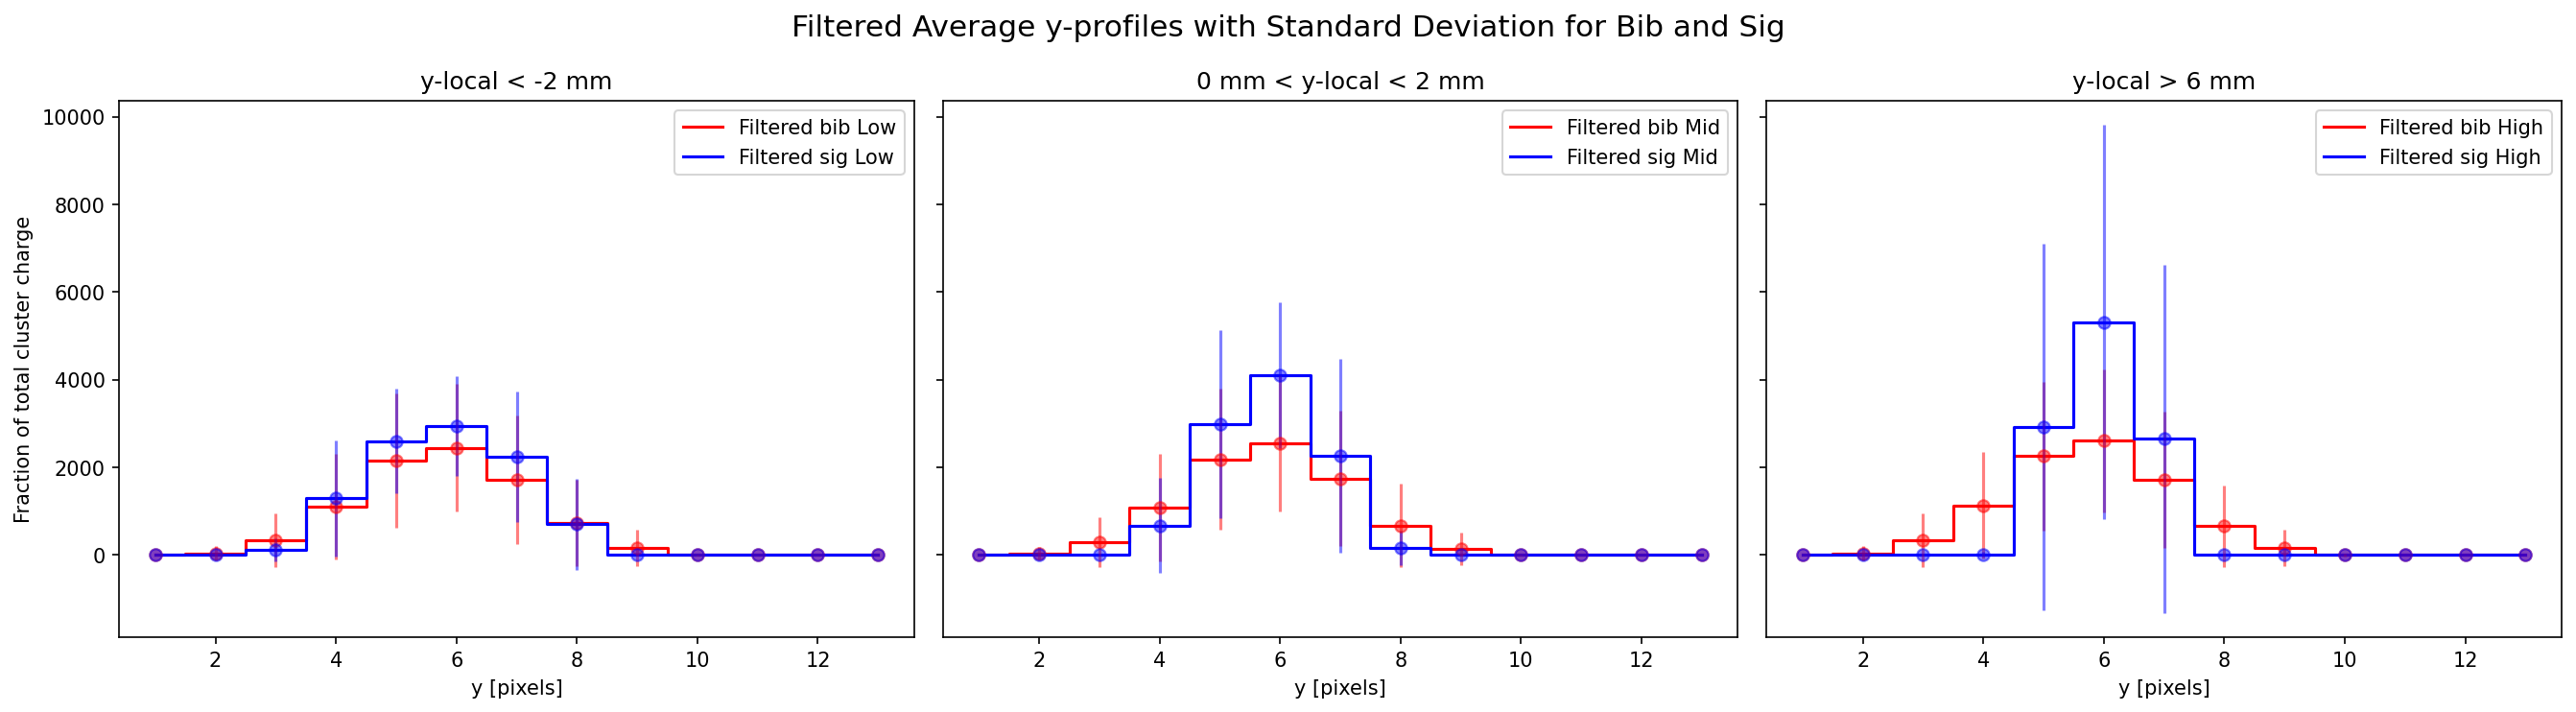

In [12]:
# Define the y-axis and data (replace these with actual filtered profile data and std deviations)
yaxis = np.arange(1, len(filtered_profilebibLow) + 1, 1)
std_profilebibLow = np.std(getYProfiles(filtered_clustersbibLow), axis=0)
std_profilebibMid = np.std(getYProfiles(filtered_clustersbibMid), axis=0)
std_profilebibHigh = np.std(getYProfiles(filtered_clustersbibHigh), axis=0)
std_profilesigLow = np.std(getYProfiles(filtered_clusterssigLow), axis=0)
std_profilesigMid = np.std(getYProfiles(filtered_clusterssigMid), axis=0)
std_profilesigHigh = np.std(getYProfiles(filtered_clusterssigHigh), axis=0)

# Plot
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18, 5))

# Plot for Low profiles with whiskers
ax[0].step(yaxis, filtered_profilebibLow, where="mid", label="Filtered bib Low", color='r')
ax[0].step(yaxis, filtered_profilesigLow, where="mid", label="Filtered sig Low", color='b')
ax[0].errorbar(yaxis, filtered_profilebibLow, yerr=std_profilebibLow, fmt='o', color='r', alpha=0.5)
ax[0].errorbar(yaxis, filtered_profilesigLow, yerr=std_profilesigLow, fmt='o', color='b', alpha=0.5)
ax[0].legend()
ax[0].set_title("y-local < -2 mm")
ax[0].set_ylabel("Fraction of total cluster charge")
ax[0].set_xlabel("y [pixels]")

# Plot for Mid profiles with whiskers
ax[1].step(yaxis, filtered_profilebibMid, where="mid", label="Filtered bib Mid", color='r')
ax[1].step(yaxis, filtered_profilesigMid, where="mid", label="Filtered sig Mid", color='b')
ax[1].errorbar(yaxis, filtered_profilebibMid, yerr=std_profilebibMid, fmt='o', color='r', alpha=0.5)
ax[1].errorbar(yaxis, filtered_profilesigMid, yerr=std_profilesigMid, fmt='o', color='b', alpha=0.5)
ax[1].legend()
ax[1].set_title("0 mm < y-local < 2 mm")
ax[1].set_xlabel("y [pixels]")

# Plot for High profiles with whiskers
ax[2].step(yaxis, filtered_profilebibHigh, where="mid", label="Filtered bib High", color='r')
ax[2].step(yaxis, filtered_profilesigHigh, where="mid", label="Filtered sig High", color='b')
ax[2].errorbar(yaxis, filtered_profilebibHigh, yerr=std_profilebibHigh, fmt='o', color='r', alpha=0.5)
ax[2].errorbar(yaxis, filtered_profilesigHigh, yerr=std_profilesigHigh, fmt='o', color='b', alpha=0.5)
ax[2].legend()
ax[2].set_title("y-local > 6 mm")
ax[2].set_xlabel("y [pixels]")

# Add an overall title and layout adjustments
fig.suptitle('Filtered Average y-profiles with Standard Deviation for Bib and Sig', fontsize=15)
plt.tight_layout()
plt.show()

In [13]:
cov_matrix = covariance_matrix_sig_low_filtered
mean_vector = filtered_profilesigLow

# Random vector to test (same length as mean_vector)
random_vector = np.random.rand(mean_vector.shape[0])

# random_vector = np.zeros_like(mean_vector)

# Compute the Mahalanobis distance
distance = Mahalanobis_Distance(cov_matrix, mean_vector, random_vector)

print(Mahalanobis_Probability(distance, mean_vector.shape[0]))

0.9974191133908796


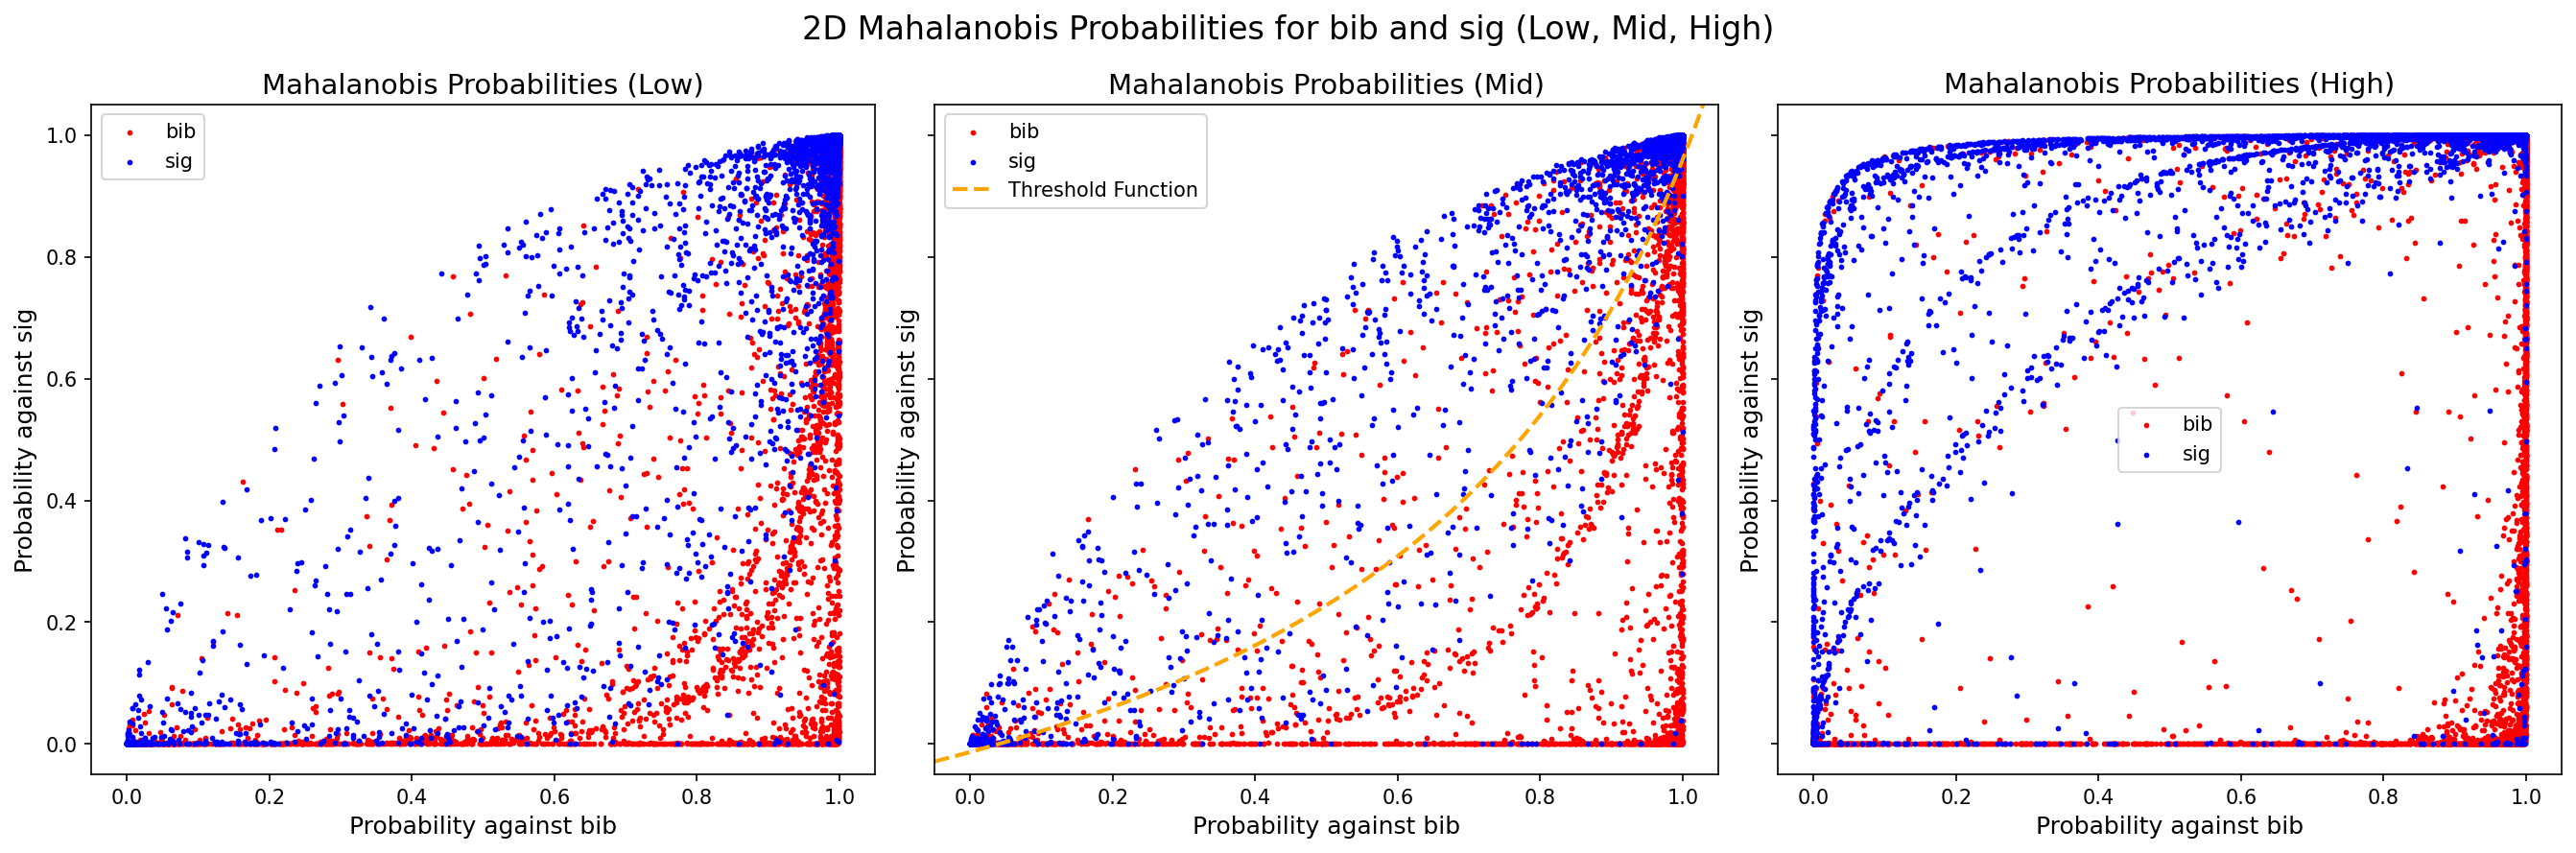

In [15]:
# Import numpy for generating the x-coordinates for the custom function
import numpy as np

# Define the custom function as provided
def custom_function(x, a, shift=0.01):
    """
    Custom function used for filtering data points.
    Parameters:
        x: Input x-coordinate.
        a: Parameter defining the function behavior.
        shift: Shift parameter for the function.
    Returns:
        Computed y-coordinate for the function.
    """
    f_a = np.tan(np.pi * a / 2)
    result = (x - shift) / ((x - shift) + f_a * (1 - (x - shift))) - shift
    return result

# Datasets, labels, and colors
datasets_low = [clustersbibLow, clusterssigLow]
datasets_mid = [clustersbibMid, clusterssigMid]
datasets_high = [clustersbibHigh, clusterssigHigh]

dataset_labels = ['bib', 'sig']
dataset_colors = ['red', 'blue']

# Create subplots for Low, Mid, and High
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for Low
create_2d_mahalanobis_plot(datasets_low, dataset_labels, dataset_colors,
                           datasets_low, 'Mahalanobis Probabilities (Low)', axes[0])

# Plot for Mid
create_2d_mahalanobis_plot(datasets_mid, dataset_labels, dataset_colors,
                           datasets_mid, 'Mahalanobis Probabilities (Mid)', axes[1])

# Add the threshold line for "Mid"
x_values = np.linspace(-0.05, 1.05, 500)  # Generate x values for the function
a = 0.8
shift = 0.01
y_values = custom_function(x_values, a, shift)  # Compute y values using the custom function

axes[1].plot(x_values, y_values, '--', color='orange', linewidth=2, label='Threshold Function')  # Add thicker dashed line
axes[1].legend(loc='best')  # Update legend

# Plot for High
create_2d_mahalanobis_plot(datasets_high, dataset_labels, dataset_colors,
                           datasets_high, 'Mahalanobis Probabilities (High)', axes[2])

# Add an overall title and show the plots
fig.suptitle('2D Mahalanobis Probabilities for bib and sig (Low, Mid, High)', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:

# Define a function to create the plots for given datasets and references
'''
def compute_probabilities_2d(dataset, reference_datasets):
    """
    Compute probabilities for each profile in a dataset against two reference datasets.

    Parameters:
        dataset: The dataset to process (e.g., clustersLow1).
        reference_datasets: List of two reference datasets for covariance and mean.

    Returns:
        List of tuples containing probabilities for the dataset against each reference.
    """
    probabilities = []
    for profile in getYProfiles(dataset):
        prob_ref1 = Mahalanobis_Probability(
            Mahalanobis_Distance(
                getCovarianceMatrixY(reference_datasets[0]),
                getAverageYProfile(reference_datasets[0]),
                profile
            ),
            getAverageYProfile(reference_datasets[0]).shape[0]
        )
        prob_ref2 = Mahalanobis_Probability(
            Mahalanobis_Distance(
                getCovarianceMatrixY(reference_datasets[1]),
                getAverageYProfile(reference_datasets[1]),
                profile
            ),
            getAverageYProfile(reference_datasets[1]).shape[0]
        )
        probabilities.append((prob_ref1, prob_ref2))
    return probabilities


def create_2d_mahalanobis_plot(datasets, dataset_labels, dataset_colors, reference_datasets, plot_title, ax):
    """
    Create a 2D scatter plot for Mahalanobis probabilities.

    Parameters:
        datasets: List of datasets to process.
        dataset_labels: List of labels for the datasets.
        dataset_colors: List of colors for the datasets.
        reference_datasets: List of two reference datasets.
        plot_title: Title of the plot.
        ax: Axis object to plot on.
    """
    all_probabilities_2d = {}
    for idx, dataset in enumerate(datasets):
        dataset_name = dataset_labels[idx]
        all_probabilities_2d[dataset_name] = compute_probabilities_2d(dataset, reference_datasets)

    for idx, dataset_name in enumerate(dataset_labels):
        probabilities = all_probabilities_2d[dataset_name]
        probs_ref1, probs_ref2 = zip(*probabilities)

        ax.scatter(probs_ref1, probs_ref2,
                   c=dataset_colors[idx], marker='o', s=3,
                   label=f'{dataset_name}')
    
    ax.set_xlabel(f'Probability against {dataset_labels[0]}', fontsize=12)
    ax.set_ylabel(f'Probability against {dataset_labels[1]}', fontsize=12)
    ax.set_title(plot_title, fontsize=14)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.legend(loc='best')

# Datasets, labels, and colors
datasets_low = [clustersbibLow, clusterssigLow]
datasets_mid = [clustersbibMid, clusterssigMid]
datasets_high = [clustersbibHigh, clusterssigHigh]

dataset_labels = ['bib', 'sig']
dataset_colors = ['red', 'blue']

# Create subplots for Low, Mid, and High
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for Low
create_2d_mahalanobis_plot(datasets_low, dataset_labels, dataset_colors,
                           datasets_low, 'Mahalanobis Probabilities (Low)', axes[0])

# Plot for Mid
create_2d_mahalanobis_plot(datasets_mid, dataset_labels, dataset_colors,
                           datasets_mid, 'Mahalanobis Probabilities (Mid)', axes[1])

# Plot for High
create_2d_mahalanobis_plot(datasets_high, dataset_labels, dataset_colors,
                           datasets_high, 'Mahalanobis Probabilities (High)', axes[2])

# Add an overall title and show the plots
fig.suptitle('2D Mahalanobis Probabilities for bib and sig (Low, Mid, High)', fontsize=16)
plt.tight_layout()
plt.show()
'''

NameError: name 'clustersbibLow' is not defined

In [14]:
import numpy as np

# Define the custom function
def custom_function(x, a, shift=0.01):
    """
    Custom function used for filtering data points.
    Parameters:
        x: Input x-coordinate.
        a: Parameter defining the function behavior.
        shift: Shift parameter for the function.
    Returns:
        Computed y-coordinate for the function.
    """
    f_a = np.tan(np.pi * a / 2)
    result = (x - shift) / ((x - shift) + f_a * (1 - (x - shift))) - shift
    return result


# Compute probabilities for Low, Mid, and High datasets
probabilities_low = {}
probabilities_mid = {}
probabilities_high = {}

# Compute probabilities for Low datasets
probabilities_low['bibLow'] = compute_probabilities_2d(datasets_low[0], datasets_low)
probabilities_low['sigLow'] = compute_probabilities_2d(datasets_low[1], datasets_low)

# Compute probabilities for Mid datasets
probabilities_mid['bibMid'] = compute_probabilities_2d(datasets_mid[0], datasets_mid)
probabilities_mid['sigMid'] = compute_probabilities_2d(datasets_mid[1], datasets_mid)

# Compute probabilities for High datasets
probabilities_high['bibHigh'] = compute_probabilities_2d(datasets_high[0], datasets_high)
probabilities_high['sigHigh'] = compute_probabilities_2d(datasets_high[1], datasets_high)



In [15]:
def calculate_efficiency_and_reduction(probabilities, custom_func_params):
    """
    Calculate signal efficiency and data reduction for the given probabilities using the custom function.

    Parameters:
        probabilities (dict): Dictionary containing 'bib' and 'sig' probabilities for each dataset.
        custom_func_params (dict): Parameters for the custom function (e.g., {'a': 0.5, 'shift': 0.05}).

    Returns:
        dict: Dictionary containing signal efficiency and data reduction for each dataset.
    """
    results = {}

    # Extract parameters for the custom function
    a = custom_func_params.get("a", 0.5)
    shift = custom_func_params.get("shift", 0.05)

    # Iterate over datasets (e.g., 'Low', 'Mid', 'High')
    for key in probabilities:
        bib = probabilities[key]['bib']
        sig = probabilities[key]['sig']

        # Count sig points above the custom function
        sig_above = sum(1 for x, y in sig if y > custom_function(x, a, shift))
        sig_total = len(sig)

        # Calculate signal efficiency
        signal_efficiency = sig_above / sig_total if sig_total > 0 else 0

        # Combine bib and sig for data reduction calculation
        combined = bib + sig
        total_points = len(combined)
        points_below = sum(1 for x, y in combined if y <= custom_function(x, a, shift))

        # Calculate data reduction
        data_reduction = points_below / total_points if total_points > 0 else 0

        # Store results
        results[key] = {
            "signal_efficiency": signal_efficiency,
            "data_reduction": data_reduction,
        }

    return results


# Example usage
custom_func_params = {"a": 0.99, "shift": 0.05}

# Define probabilities for Low, Mid, and High datasets
probabilities = {
    "Low": {"bib": probabilities_low["bibLow"], "sig": probabilities_low["sigLow"]},
    "Mid": {"bib": probabilities_mid["bibMid"], "sig": probabilities_mid["sigMid"]},
    "High": {"bib": probabilities_high["bibHigh"], "sig": probabilities_high["sigHigh"]},
}

# Calculate results
results = calculate_efficiency_and_reduction(probabilities, custom_func_params)

# Output the results
print("Results:", results)


Results: {'Low': {'signal_efficiency': 0.9981911785167664, 'data_reduction': 0.031363805276848754}, 'Mid': {'signal_efficiency': 0.9988395225464191, 'data_reduction': 0.04106051476284755}, 'High': {'signal_efficiency': 0.9947183098591549, 'data_reduction': 0.07570011668611436}}


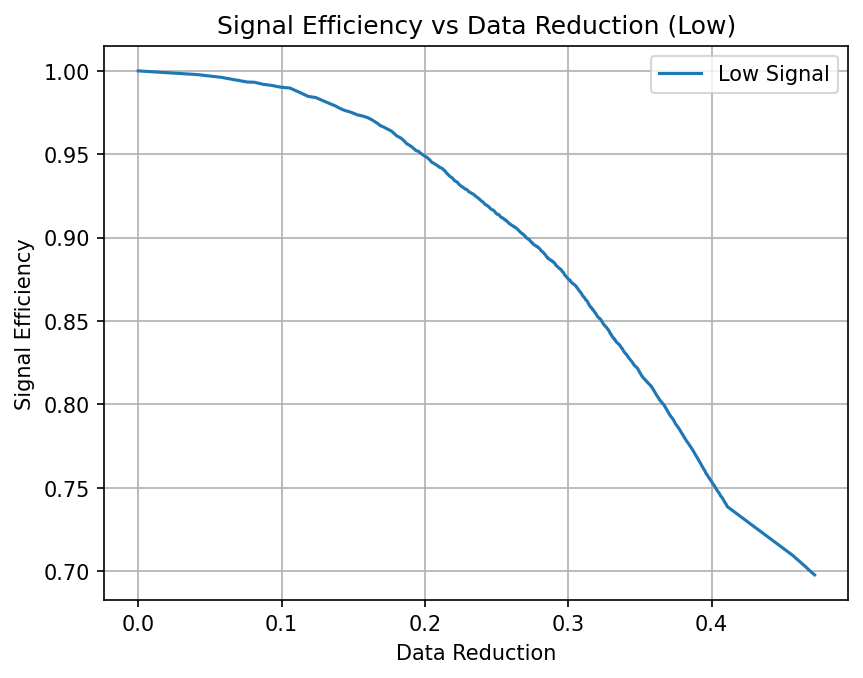

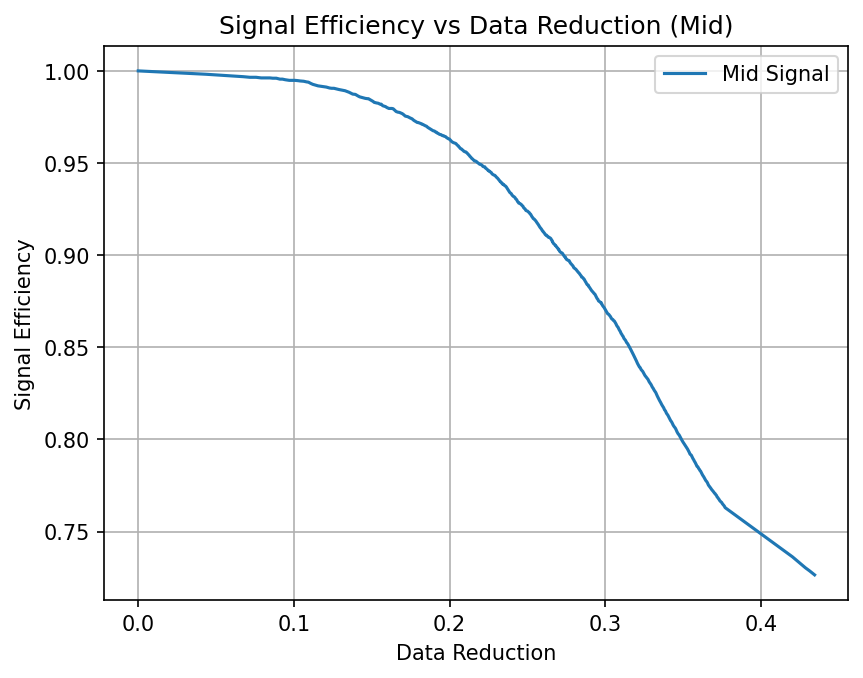

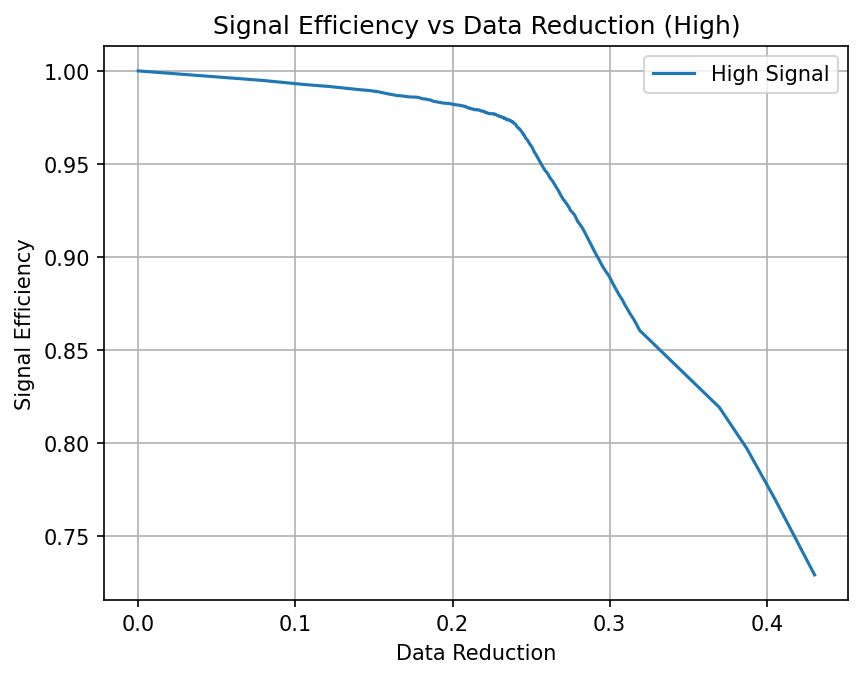

In [16]:
import matplotlib.pyplot as plt

# Assuming probabilities_low, probabilities_mid, and probabilities_high are already computed
probabilities = {
    "Low": {
        "bib": probabilities_low["bibLow"],
        "sig": probabilities_low["sigLow"],
    },
    "Mid": {
        "bib": probabilities_mid["bibMid"],
        "sig": probabilities_mid["sigMid"],
    },
    "High": {
        "bib": probabilities_high["bibHigh"],
        "sig": probabilities_high["sigHigh"],
    },
}

# Define the custom function
def custom_function(x, a, shift=0.01):
    f_a = np.tan(np.pi * a / 2)
    return (x - shift) / ((x - shift) + f_a * (1 - (x - shift))) - shift

# Define the calculate_efficiency_and_reduction function
def calculate_efficiency_and_reduction(probabilities, custom_func_params):
    results = {}

    a = custom_func_params.get("a", 0.5)
    shift = custom_func_params.get("shift", 0.05)

    for key in probabilities:
        bib = probabilities[key]["bib"]
        sig = probabilities[key]["sig"]

        sig_above = sum(1 for x, y in sig if y > custom_function(x, a, shift))
        sig_total = len(sig)

        signal_efficiency = sig_above / sig_total if sig_total > 0 else 0

        combined = bib + sig
        total_points = len(combined)
        points_below = sum(1 for x, y in combined if y <= custom_function(x, a, shift))

        data_reduction = points_below / total_points if total_points > 0 else 0

        results[key] = {
            "signal_efficiency": signal_efficiency,
            "data_reduction": data_reduction,
        }

    return results

# Iterate over a range of "a" values to calculate and store results
a_values = np.linspace(0, 1, 500)
results_over_a_non_filtered = {key: {"efficiency": [], "reduction": []} for key in probabilities}

for a in a_values:
    custom_func_params = {"a": a, "shift": 0.01}
    results = calculate_efficiency_and_reduction(probabilities, custom_func_params)
    for key in probabilities:
        results_over_a_non_filtered[key]["efficiency"].append(results[key]["signal_efficiency"])
        results_over_a_non_filtered[key]["reduction"].append(results[key]["data_reduction"])

# Plot Signal Efficiency vs Data Reduction for each category
for category in ["Low", "Mid", "High"]:
    plt.figure()
    plt.plot(
        results_over_a_non_filtered[category]["reduction"],
        results_over_a_non_filtered[category]["efficiency"],
        label=f"{category} Signal",
    )
    plt.title(f"Signal Efficiency vs Data Reduction ({category})")
    plt.xlabel("Data Reduction")
    plt.ylabel("Signal Efficiency")
    plt.legend()
    plt.grid()
    plt.show()




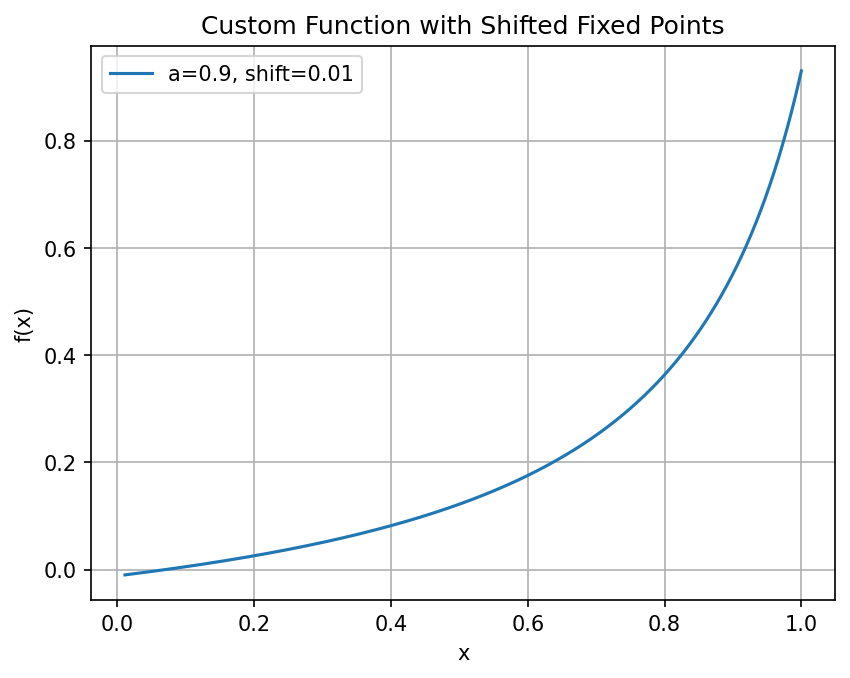

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def custom_function(x, a, shift=0.01):
    # Define f(a) as tan(pi * a / 2)
    f_a = np.tan(np.pi * a / 2)
    # Compute the shifted function using the shift parameter
    result = (x - shift) / ((x - shift) + f_a * (1 - (x - shift))) - shift
    return result

# Example usage
a = 0.9  # Example value for a
shift = 0.01  # Default shift value
x = np.linspace(shift + 0.001, 1, 10000)  # Avoid division by zero
y = custom_function(x, a, shift)

# Plot the function for visualization
plt.plot(x, y, label=f'a={a}, shift={shift}')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Custom Function with Shifted Fixed Points')
plt.legend()
plt.grid()
plt.show()

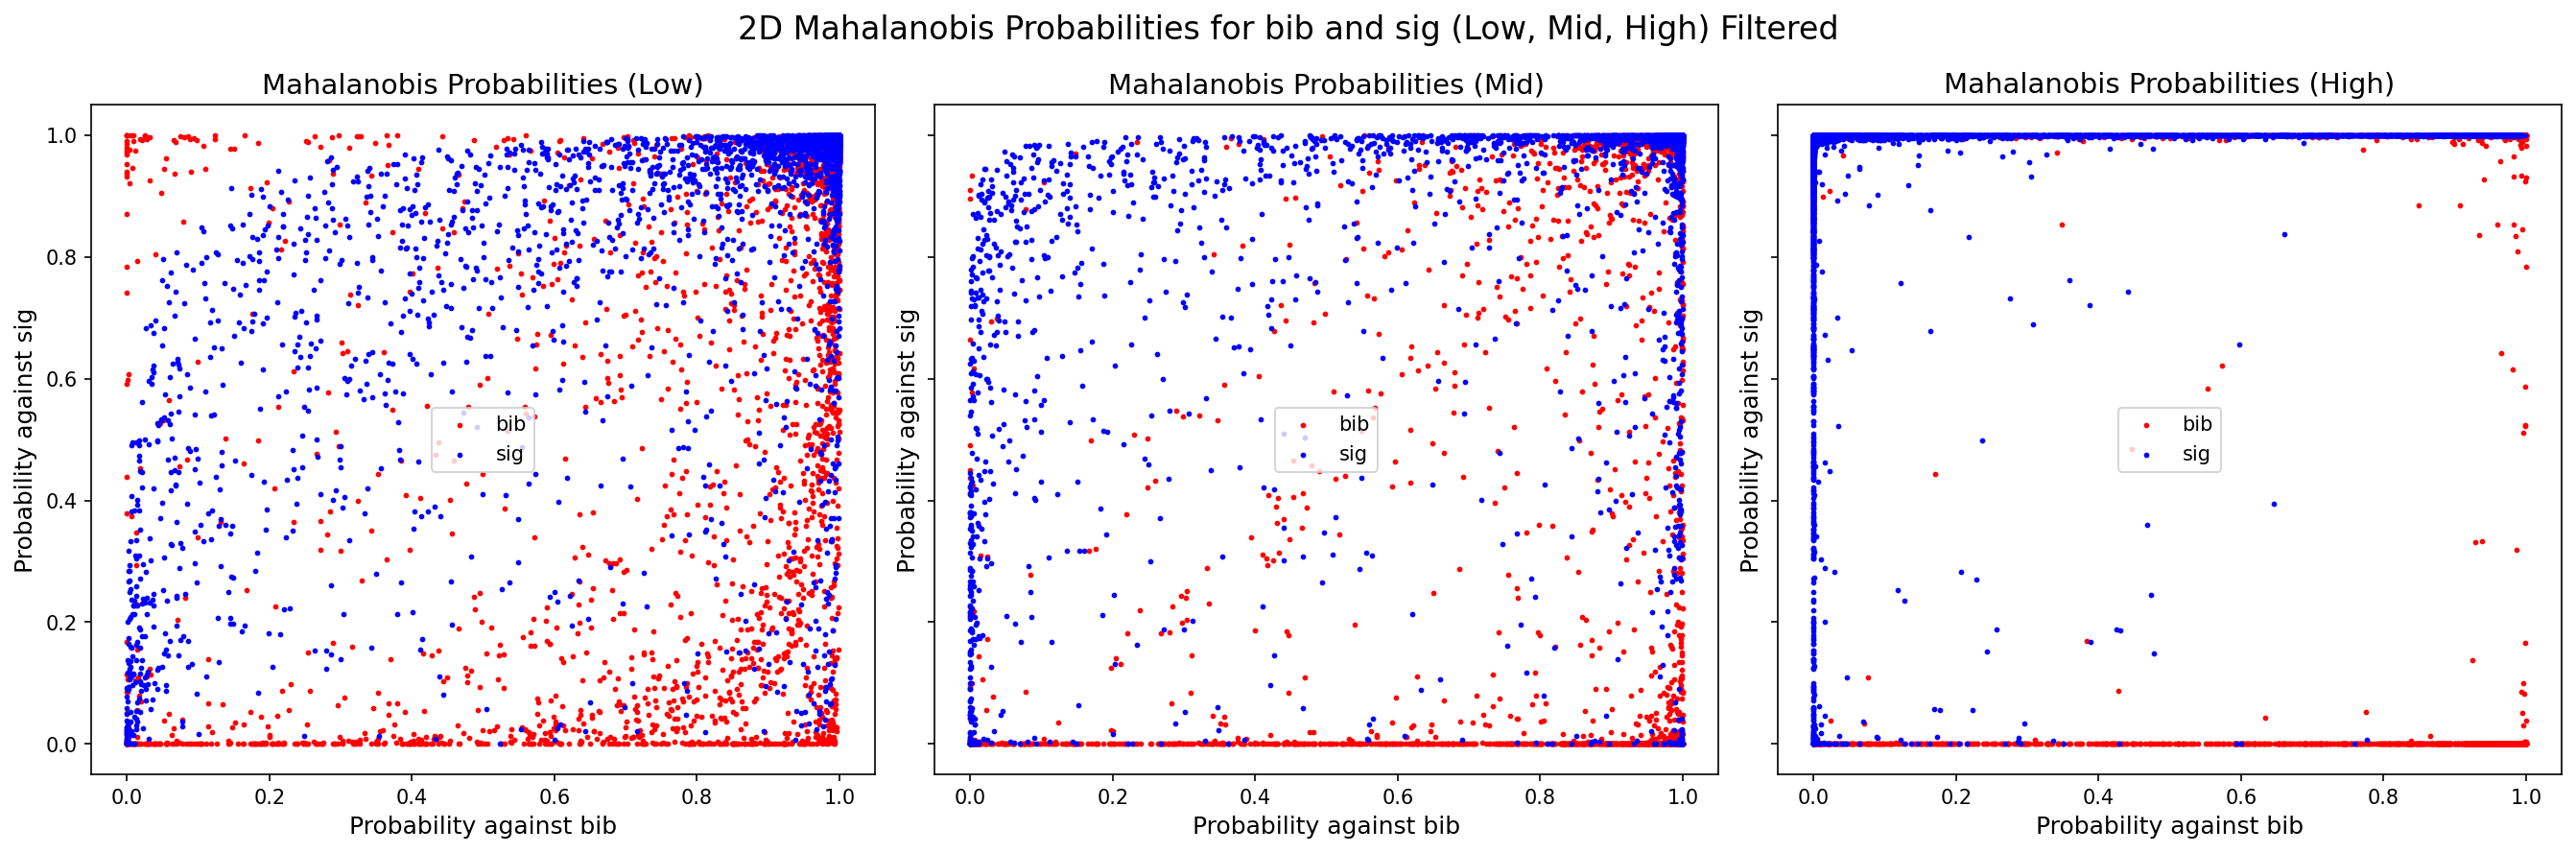

In [18]:
# Datasets, labels, and colors
filtered_datasets_low = [filtered_clustersbibLow, filtered_clusterssigLow]
filtered_datasets_mid = [filtered_clustersbibMid, filtered_clusterssigMid]
filtered_datasets_high = [filtered_clustersbibHigh, filtered_clusterssigHigh]

dataset_labels = ['bib', 'sig']
dataset_colors = ['red', 'blue']

# Create subplots for Low, Mid, and High
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for Low
create_2d_mahalanobis_plot(filtered_datasets_low, dataset_labels, dataset_colors,
                           filtered_datasets_low, 'Mahalanobis Probabilities (Low)', axes[0])

# Plot for Mid
create_2d_mahalanobis_plot(filtered_datasets_mid, dataset_labels, dataset_colors,
                           filtered_datasets_mid, 'Mahalanobis Probabilities (Mid)', axes[1])

# Plot for High
create_2d_mahalanobis_plot(filtered_datasets_high, dataset_labels, dataset_colors,
                           filtered_datasets_high, 'Mahalanobis Probabilities (High)', axes[2])

# Add an overall title and show the plots
fig.suptitle('2D Mahalanobis Probabilities for bib and sig (Low, Mid, High) Filtered', fontsize=16)
plt.tight_layout()
plt.show()

In [19]:

# Compute probabilities for Low, Mid, and High datasets
probabilities_low_filtered = {}
probabilities_mid_filtered = {}
probabilities_high_filtered = {}

# Compute probabilities for Low datasets
probabilities_low_filtered['bibLow'] = compute_probabilities_2d(filtered_datasets_low[0], filtered_datasets_low)
probabilities_low_filtered['sigLow'] = compute_probabilities_2d(filtered_datasets_low[1], filtered_datasets_low)

# Compute probabilities for Mid datasets
probabilities_mid_filtered['bibMid'] = compute_probabilities_2d(filtered_datasets_mid[0], filtered_datasets_mid)
probabilities_mid_filtered['sigMid'] = compute_probabilities_2d(filtered_datasets_mid[1], filtered_datasets_mid)

# Compute probabilities for High datasets
probabilities_high_filtered['bibHigh'] = compute_probabilities_2d(filtered_datasets_high[0], filtered_datasets_high)
probabilities_high_filtered['sigHigh'] = compute_probabilities_2d(filtered_datasets_high[1], filtered_datasets_high)

# Example usage
custom_func_params = {"a": 0.9, "shift": 0.05}

# Define probabilities for Low, Mid, and High datasets
probabilities_filtered = {
    "Low": {"bib": probabilities_low_filtered["bibLow"], "sig": probabilities_low_filtered["sigLow"]},
    "Mid": {"bib": probabilities_mid_filtered["bibMid"], "sig": probabilities_mid_filtered["sigMid"]},
    "High": {"bib": probabilities_high_filtered["bibHigh"], "sig": probabilities_high_filtered["sigHigh"]},
}

# Calculate results
results = calculate_efficiency_and_reduction(probabilities_filtered, custom_func_params)

# Output the results
print("Results:", results)

Results: {'Low': {'signal_efficiency': 0.9637227920940705, 'data_reduction': 0.14546542951212213}, 'Mid': {'signal_efficiency': 0.9472704714640199, 'data_reduction': 0.22333571939871152}, 'High': {'signal_efficiency': 0.9984871406959153, 'data_reduction': 0.1819315505057503}}


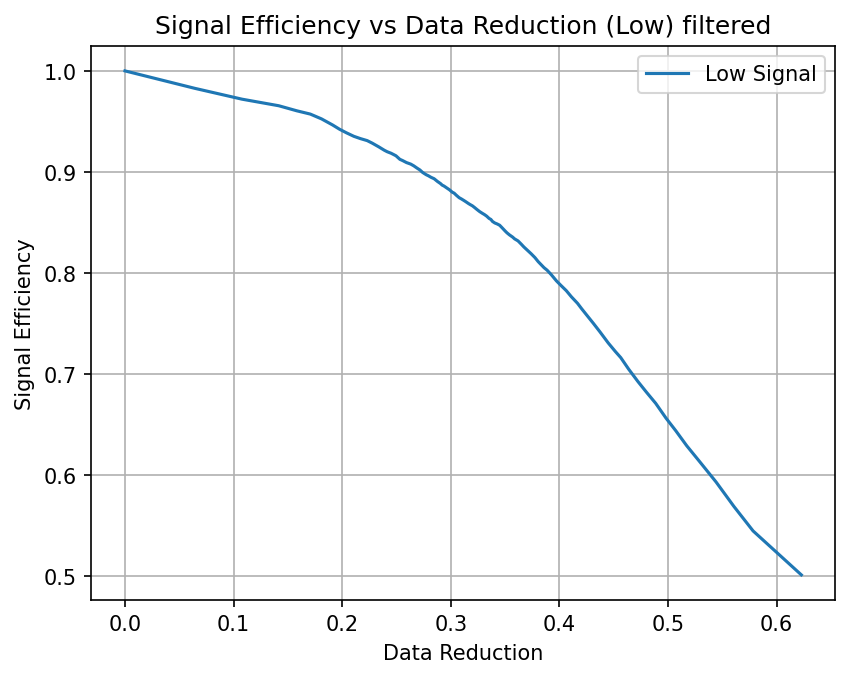

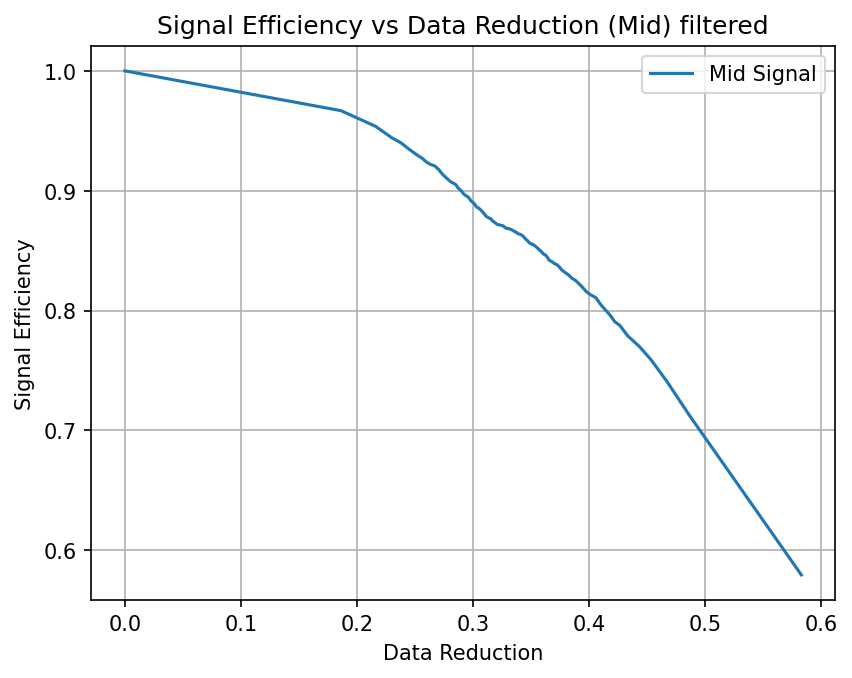

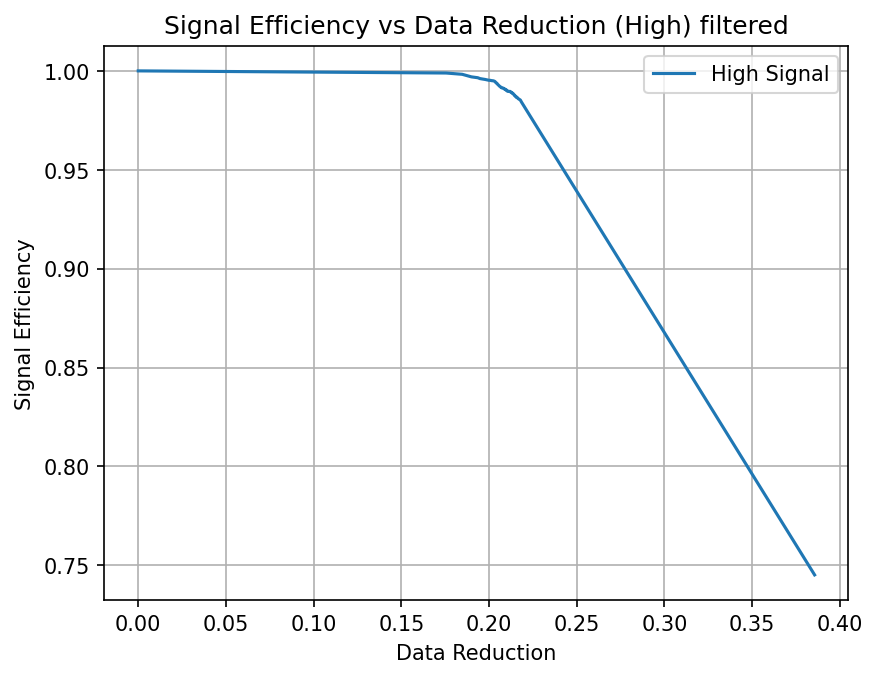

In [20]:
# Iterate over a range of "a" values to calculate and store results
a_values = np.linspace(0, 1, 100)
results_over_a_filtered = {key: {"efficiency": [], "reduction": []} for key in probabilities_filtered}

for a in a_values:
    custom_func_params = {"a": a, "shift": 0.01}
    results = calculate_efficiency_and_reduction(probabilities_filtered, custom_func_params)
    for key in probabilities_filtered:
        results_over_a_filtered[key]["efficiency"].append(results[key]["signal_efficiency"])
        results_over_a_filtered[key]["reduction"].append(results[key]["data_reduction"])

# Plot Signal Efficiency vs Data Reduction for each category
for category in ["Low", "Mid", "High"]:
    plt.figure()
    plt.plot(
        results_over_a_filtered[category]["reduction"],
        results_over_a_filtered[category]["efficiency"],
        label=f"{category} Signal",
    )
    plt.title(f"Signal Efficiency vs Data Reduction ({category}) filtered")
    plt.xlabel("Data Reduction")
    plt.ylabel("Signal Efficiency")
    plt.legend()
    plt.grid()
    plt.show()

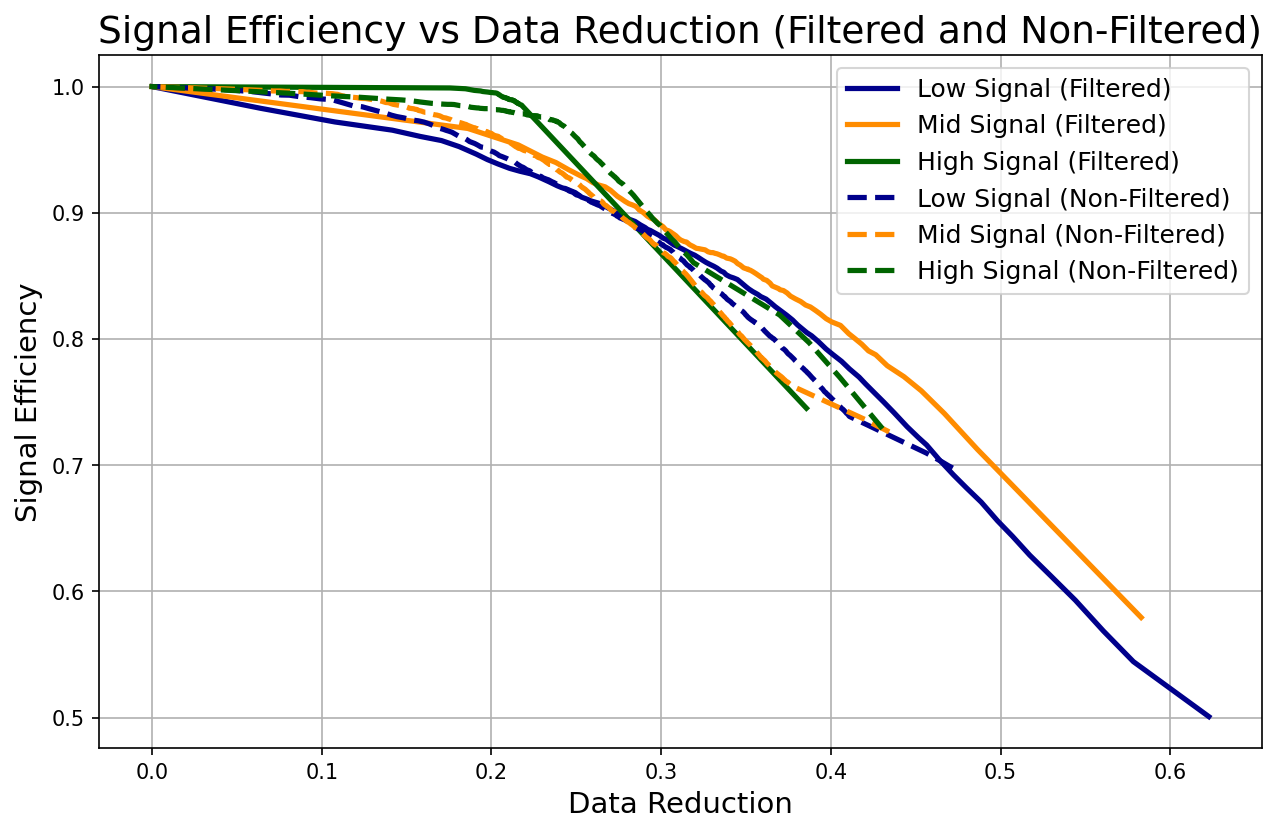

In [21]:
# Categories and colors
categories = ["Low", "Mid", "High"]
colors = ["darkblue", "darkorange", "darkgreen"]  # Use darker, more visible colors

# Line styles for filtered and non-filtered
linestyles = {"filtered": "solid", "non-filtered": "dashed"}

# Create the figure
plt.figure(figsize=(10, 6))

# Plot for filtered data
for category, color in zip(categories, colors):
    plt.plot(
        results_over_a_filtered[category]["reduction"],
        results_over_a_filtered[category]["efficiency"],
        label=f"{category} Signal (Filtered)",
        color=color,
        linestyle=linestyles["filtered"],
        linewidth=2.5,  # Make lines thicker
    )

# Plot for non-filtered data
for category, color in zip(categories, colors):
    plt.plot(
        results_over_a_non_filtered[category]["reduction"],
        results_over_a_non_filtered[category]["efficiency"],
        label=f"{category} Signal (Non-Filtered)",
        color=color,
        linestyle=linestyles["non-filtered"],
        linewidth=2.5,  # Make lines thicker
    )

# Add labels and title
plt.xlabel("Data Reduction", fontsize=14)
plt.ylabel("Signal Efficiency", fontsize=14)
plt.title("Signal Efficiency vs Data Reduction (Filtered and Non-Filtered)", fontsize=18)
plt.legend(fontsize=12)
plt.grid()

# Show the plot
plt.show()


Covariance Matrix Shape: (13, 13)
Mahalanobis Distance: 96.58322218882006
0.0


/tmp/ipykernel_3546644/734704039.py:549: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_3546644/734704039.py:618: RuntimeWarning:

invalid value encountered in divide



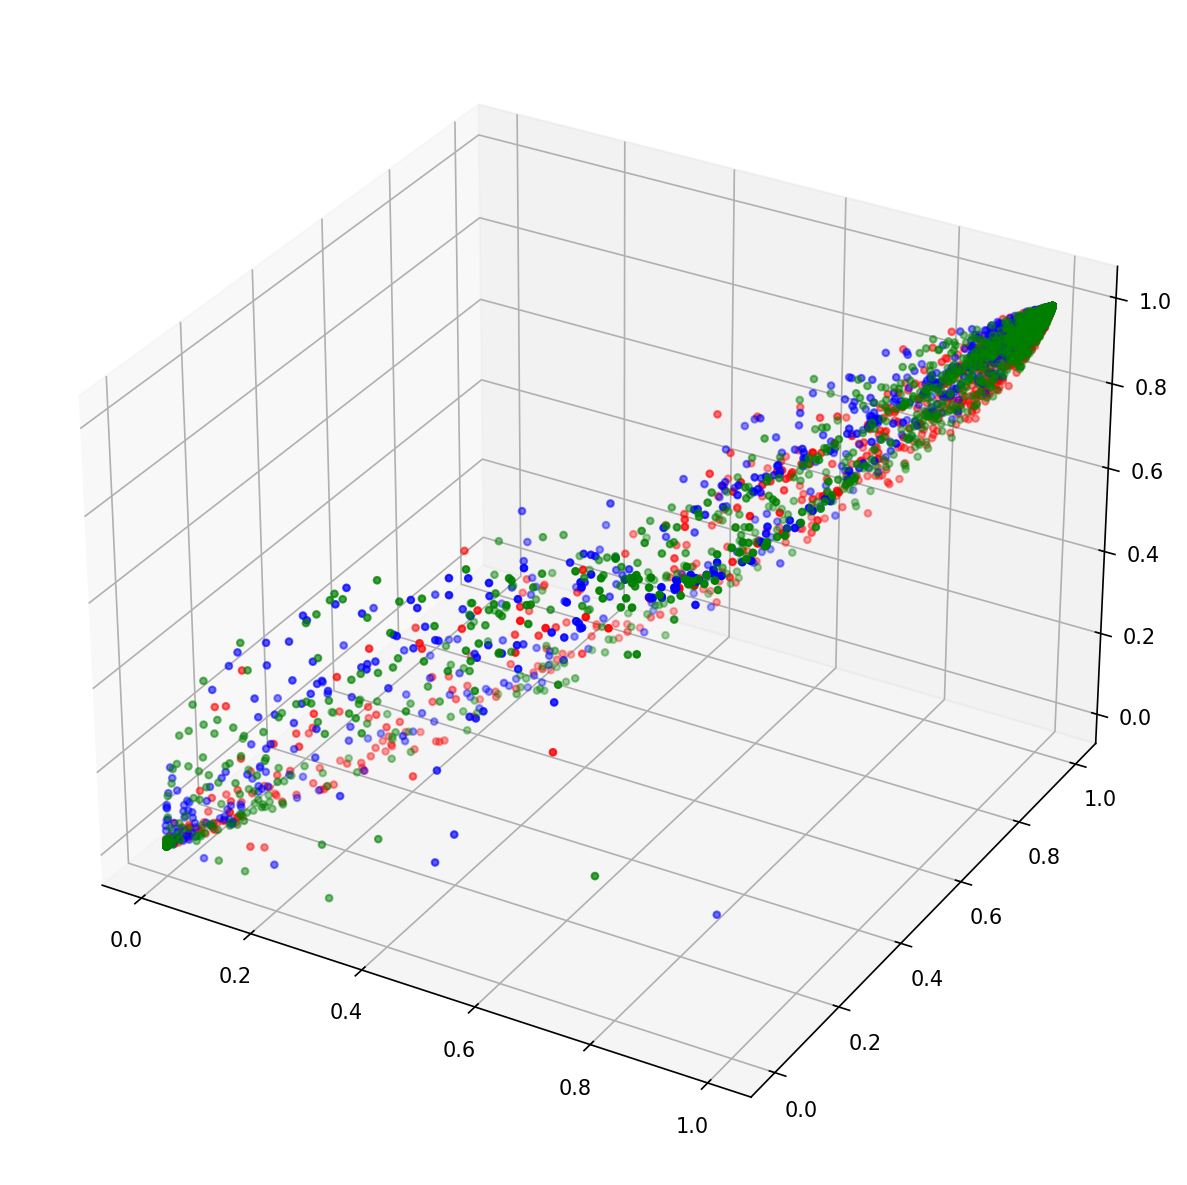

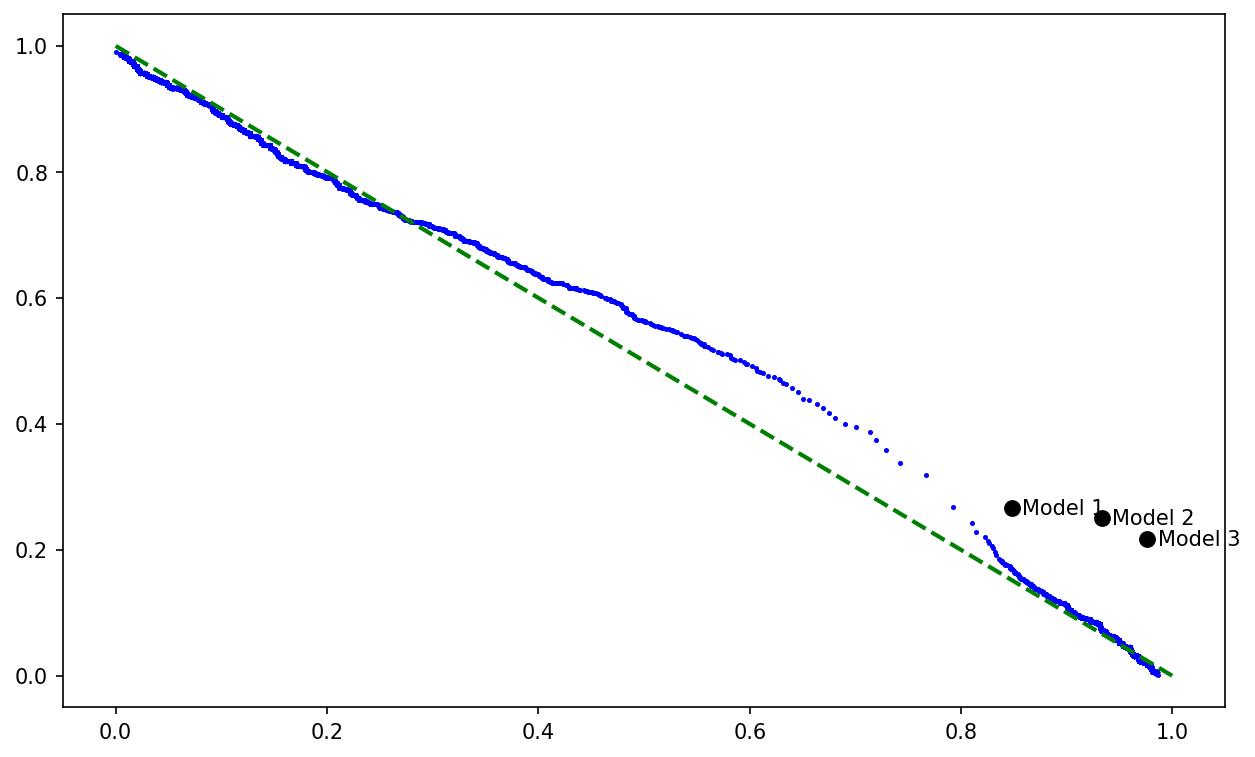

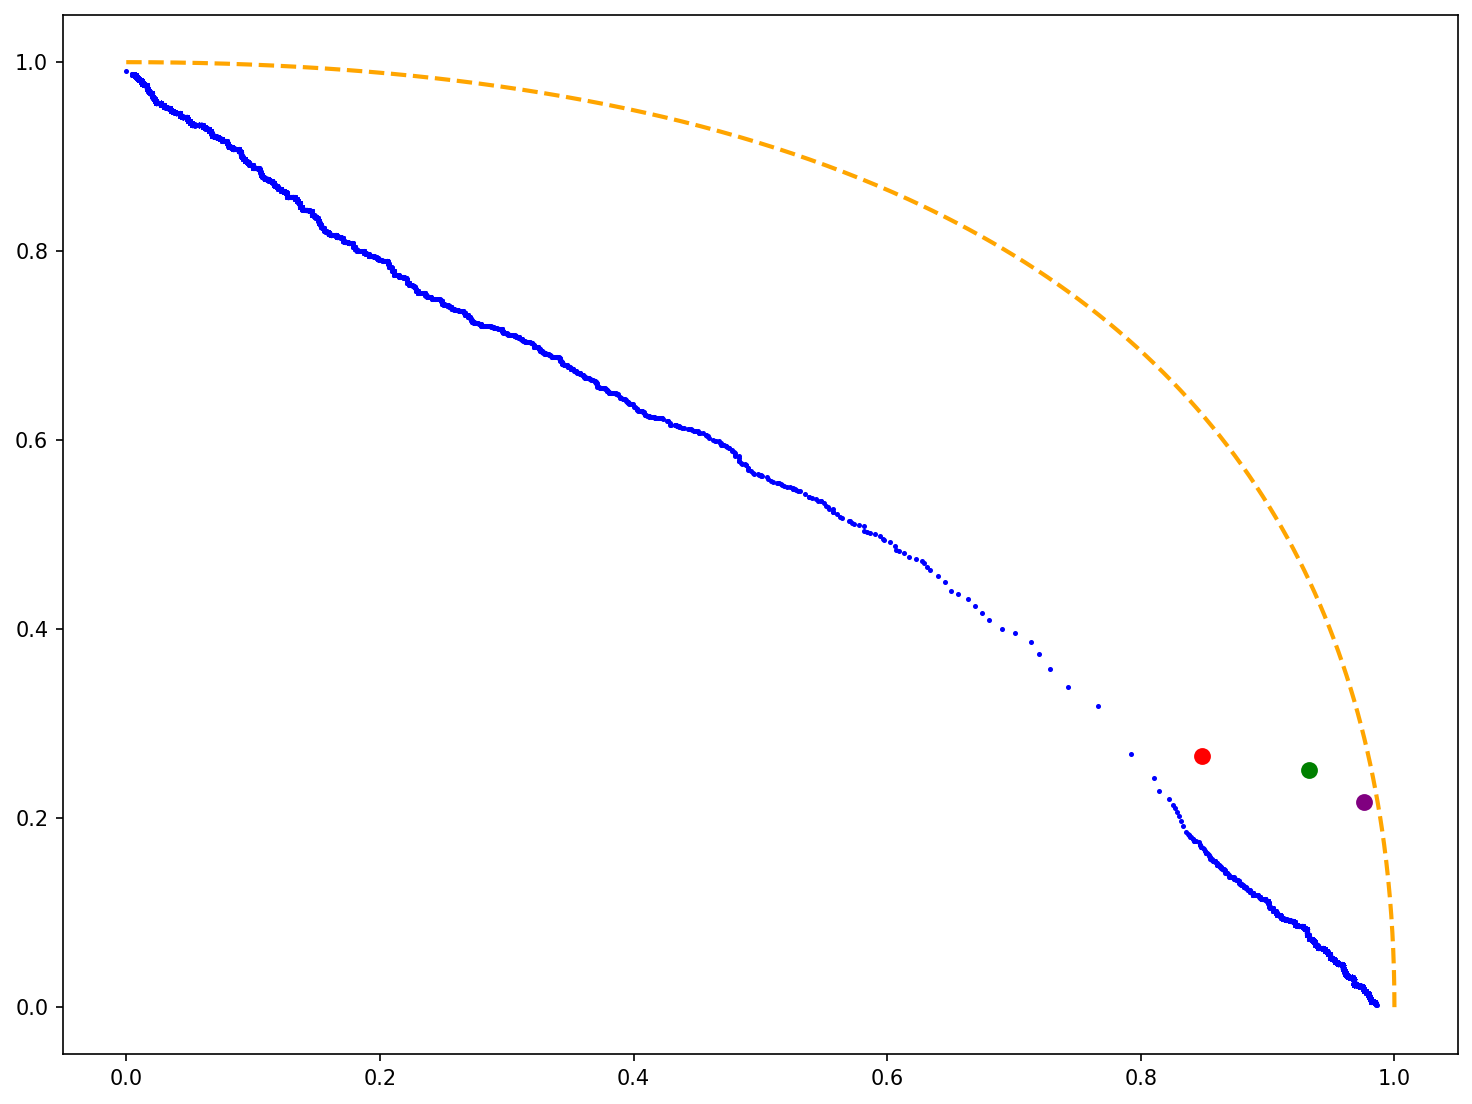

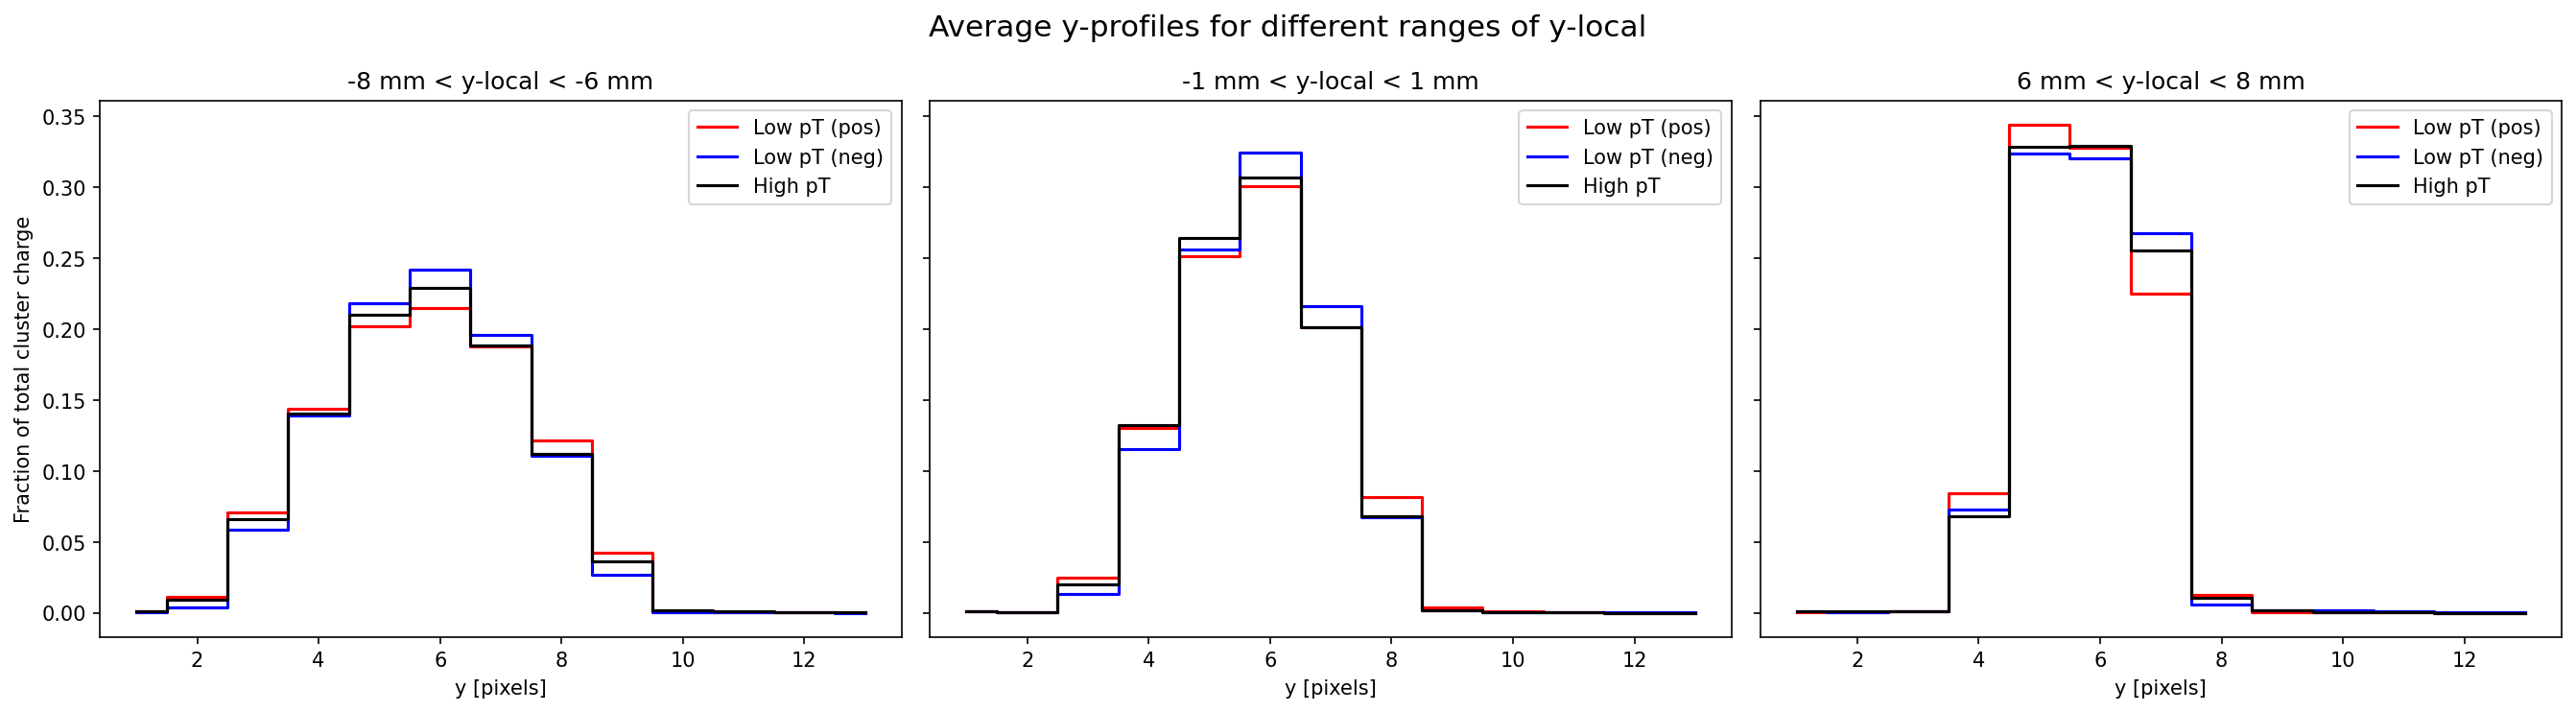

In [ ]:
# %%
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt                               
import os 
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
matplotlib.rcParams["figure.dpi"] = 150
from particle import PDGID
from utils import delphesRootToPixelAvTrackList as utils

# %%
datadir = '/home/youeric/PixelSim/cmspix28-mc-sim/TestDataUnflippedVertexCut3'
flp = 0

# %%
import subprocess
import os

'''
def run_parquet_conversion(out_file_path, out_dir, tag):
    # Define the parquet command
    parquet_command = [
        "python3",
        "./processing/datagen.py",
        "-f", out_file_path,
        "-t", tag,
        "-d", out_dir
    ]
    
    # Run the parquet command
    subprocess.run(parquet_command)

if __name__ == "__main__":
    # Define the specific .out file and its details
    out_file_path = "/minbias_0.00_0.10_GeV.out"
    tag = "minbias_0.00_0.10_GeV"
    out_dir = os.path.abspath("./TestDataUnflippedVertexCut")
    
    # Run the parquet conversion
    run_parquet_conversion(out_file_path, out_dir, tag)
'''

# %%
# Load the parquet file
data = pd.read_parquet(datadir+"/recon2Dminbias_0.00_0.50_GeV.parquet")

# %%
truthLow = pd.read_parquet(datadir+"/labelsminbias_0.00_0.50_GeV.parquet")    # file of id's
recon2DLow = pd.read_parquet(datadir+"/recon2Dminbias_0.00_0.50_GeV.parquet") # file of the tracks

Q = [] #add charge

for pid in truthLow['PID']:
    Q.append(PDGID(pid).charge)
truthLow['q'] = Q

# Seperate into positive and negative particles
cut = truthLow['q']>0
truthLowPos = truthLow[cut]
recon2DLowPos = recon2DLow[cut]
clustersLowPos = recon2DLowPos.to_numpy().reshape(recon2DLowPos.shape[0],13,21)

cut = truthLow['q']<0
truthLowNeg = truthLow[cut]
recon2DLowNeg = recon2DLow[cut]
clustersLowNeg = recon2DLowNeg.to_numpy().reshape(recon2DLowNeg.shape[0],13,21)

truthHigh = pd.read_parquet(datadir+"/labelsminbias_2.00_4.00_GeV.parquet")
recon2DHigh = pd.read_parquet(datadir+"/recon2Dminbias_2.00_4.00_GeV.parquet")
clustersHigh = recon2DHigh.to_numpy().reshape(recon2DHigh.shape[0],13,21)

Q = []
for pid in truthHigh['PID']:
    Q.append(PDGID(pid).charge)
truthHigh['q'] = Q

# Seperate into positive and negative particles
cut = truthHigh['q']>0
truthHighPos = truthHigh[cut]
recon2DHighPos = recon2DHigh[cut]
clustersHighPos = recon2DHighPos.to_numpy().reshape(recon2DHighPos.shape[0],13,21)

cut = truthHigh['q']<0
truthHighNeg = truthHigh[cut]
recon2DHighNeg = recon2DHigh[cut]
clustersLoHighNeg = recon2DHighNeg.to_numpy().reshape(recon2DHighNeg.shape[0],13,21)


# %%
def getProfiles(clusters):
    profiles = np.sum(clusters, axis = 2)
    totalCharge = np.sum(profiles, axis = 1, keepdims=True)
    return profiles/totalCharge

def getAverageProfile(clusters):
    profiles=getProfiles(clusters)
    return np.mean(profiles, axis=0)

# %%
def getClusterSizes(clusters):
    profiles=getProfiles(clusters)
    bool_arr = profiles != 0
    return np.sum(bool_arr, axis = 1)

def getAverageClusterSize(clusters):
    clusterSizes = getClusterSizes(clusters)
    return np.mean(clusterSizes)

# %%
# Seperate into out by ylocal
cut = truthLowPos['y-local']<-6

truthLowPos1 = truthLowPos[cut]
recon2DLowPos1 = recon2DLowPos[cut]
clustersLowPos1 = recon2DLowPos1.to_numpy().reshape(recon2DLowPos1.shape[0],13,21)

cut = truthLowNeg['y-local']<-6
truthLowNeg1 = truthLowNeg[cut]
recon2DLowNeg1 = recon2DLowNeg[cut]
clustersLowNeg1 = recon2DLowNeg1.to_numpy().reshape(recon2DLowNeg1.shape[0],13,21)

cut = truthHigh['y-local']<-6
truthHigh1 = truthHigh[cut]
recon2DHigh1 = recon2DHigh[cut]
clustersHigh1 = recon2DHigh1.to_numpy().reshape(recon2DHigh1.shape[0],13,21)

profileLowPos1 = getAverageProfile(clustersLowPos1)
profileLowNeg1 = getAverageProfile(clustersLowNeg1)
profileHigh1 = getAverageProfile(clustersHigh1)

# %%
clusterProfiles = getProfiles(clustersHigh1)

# %% [markdown]
# Test code on Profile low Cut

# %%
def GetMeanVector(clusters):
    clusterSizes = getAverageProfile(clusters)
    return np.mean(clusterSizes)

def getCovarianceMatrix(clusters):

    # Get the cluster size profile (non-zero pixels along axis 1 and 2 for each cluster)
    clusterProfiles = getProfiles(clusters)

    # Compute the covariance matrix
    covariance_matrix = np.cov(clusterProfiles, rowvar=False)
    
    return covariance_matrix

# Compute the covariance matrix for low-positive clusters
covariance_matrix_low_pos = getCovarianceMatrix(clustersHigh1)

# Print covariance matrix details
print("Covariance Matrix Shape:", covariance_matrix_low_pos.shape)


# %%
import matplotlib.pyplot as plt
import numpy as np

# Assuming the definitions for getClusterSizes and getProfiles already exist

def GetMeanVector(clusters):
    clusterSizes = getAverageProfile(clusters)
    return np.mean(clusterSizes)

def getCovarianceMatrix(clusters):
    # Get the cluster size profile (non-zero pixels along axis 1 and 2 for each cluster)
    clusterProfiles = getProfiles(clusters)
    # Compute the covariance matrix
    covariance_matrix = np.cov(clusterProfiles, rowvar=False)
    return covariance_matrix

# Compute covariance matrices for different clusters
covariance_matrix_high = getCovarianceMatrix(clustersHigh1)
covariance_matrix_low_pos = getCovarianceMatrix(clustersLowPos1)
covariance_matrix_low_neg = getCovarianceMatrix(clustersLowNeg1)

# Determine a common color scale
vmin = min(
    np.min(covariance_matrix_high),
    np.min(covariance_matrix_low_pos),
    np.min(covariance_matrix_low_neg),
)
vmax = max(
    np.max(covariance_matrix_high),
    np.max(covariance_matrix_low_pos),
    np.max(covariance_matrix_low_neg),
)



# %%
import numpy as np

def Mahalanobis_Distance(cov_matrix, mean_vector, random_vector):
    """
    Compute the Mahalanobis distance using the pseudoinverse for singular covariance matrices.

    Parameters:
        cov_matrix (numpy.ndarray): Covariance matrix of the distribution (shape: n x n).
        mean_vector (numpy.ndarray): Mean vector of the distribution (shape: n,).
        random_vector (numpy.ndarray): Input random vector (shape: n,).

    Returns:
        float: The Mahalanobis distance.
    """
    # Convert inputs to numpy arrays if they are not already
    cov_matrix = np.asarray(cov_matrix)
    mean_vector = np.asarray(mean_vector)
    random_vector = np.asarray(random_vector)

    # Ensure the dimensions match
    if mean_vector.shape[0] != random_vector.shape[0]:
        raise ValueError("Mean vector and random vector dimensions do not match.")
    if cov_matrix.shape[0] != cov_matrix.shape[1] or cov_matrix.shape[0] != mean_vector.shape[0]:
        raise ValueError("Covariance matrix dimensions must match the length of the mean vector.")
    
    # Compute the difference vector
    diff = random_vector - mean_vector

    # Compute the pseudoinverse of the covariance matrix
    inv_cov_matrix = np.linalg.pinv(cov_matrix)
    
    # Compute Mahalanobis distance
    distance = np.sqrt(np.dot(np.dot(diff.T, inv_cov_matrix), diff))
    return distance


# Assume clustersLowPos1 is your dataset
cov_matrix = getCovarianceMatrix(clustersLowPos1)
mean_vector = getAverageProfile(clustersLowPos1).flatten()

# Random vector to test (same length as mean_vector)
random_vector = np.random.rand(mean_vector.shape[0])

# Compute the Mahalanobis distance
distance = Mahalanobis_Distance(cov_matrix, mean_vector, random_vector)

print("Mahalanobis Distance:", distance)

# %% [markdown]
# The sample mean and covariance matrix can be quite sensitive to outliers, therefore other approaches for calculating the multivariate location and scatter of data are also commonly used when calculating the Mahalanobis distance. The Minimum Covariance Determinant approach estimates multivariate location and scatter from a subset numbering 
# h
# {\displaystyle h} data points that has the smallest variance-covariance matrix determinant.[9] The Minimum Volume Ellipsoid approach is similar to the Minimum Covariance Determinant approach in that it works with a subset of size 
# h
# {\displaystyle h} data points, but the Minimum Volume Ellipsoid estimates multivariate location and scatter from the ellipsoid of minimal volume that encapsulates the 
# h
# {\displaystyle h} data points.

# %%
from scipy.stats import chi2

def Mahalanobis_Probability(D_M, d):
    """
    Compute the probability (p-value) that a vector belongs to a given distribution.

    Parameters:
        D_M (float): Mahalanobis distance.
        d (int): Degrees of freedom (dimensionality of the vector).

    Returns:
        float: Probability that the vector belongs to the distribution.
    """
    # Compute the squared Mahalanobis distance
    D_M_squared = D_M ** 2
    
    # Compute the cumulative distribution function (CDF) for chi-squared distribution
    chi2_cdf = chi2.cdf(D_M_squared, df=d)
    
    # Compute the probability (p-value)
    p_value = 1 - chi2_cdf
    
    return p_value


# %%
# Assume clustersLowPos1 is your dataset
cov_matrix = getCovarianceMatrix(clustersHigh1)
mean_vector = getAverageProfile(clustersHigh1).flatten()

# Random vector to test (same length as mean_vector)
random_vector = np.random.rand(mean_vector.shape[0])

# Compute the Mahalanobis distance
distance = Mahalanobis_Distance(cov_matrix, mean_vector, random_vector)

print(Mahalanobis_Probability(distance, mean_vector.shape[0]))
# At least it works

# %%
import matplotlib.pyplot as plt
from collections import Counter

cov_matrix = getCovarianceMatrix(clustersHigh1)
mean_vector = getAverageProfile(clustersHigh1).flatten()
clusterProfiles = getProfiles(clustersHigh1)

# Iterate through clusterProfiles to compute Mahalanobis probabilities
probabilities = []

for profile in clusterProfiles:
    # Set the random vector as the current profile
    random_vector = profile
    
    # Compute the Mahalanobis distance
    distance = Mahalanobis_Distance(cov_matrix, mean_vector, random_vector)
    
    # Compute the probability
    prob = Mahalanobis_Probability(distance, mean_vector.shape[0])
    probabilities.append(prob)

# Bin the probabilities into discrete ranges for plotting
binned_probs = Counter((int(p * 10) / 10 for p in probabilities))  # Binning into 0.1 intervals

# Normalize the counts to compute proportions
total_profiles = sum(binned_probs.values())
bins = sorted(binned_probs.keys())
proportions = [binned_probs[b] / total_profiles for b in bins]




# %%
import matplotlib.pyplot as plt
from collections import Counter

clusterProfiles = getProfiles(clustersLowNeg1)

# Iterate through clusterProfiles to compute Mahalanobis probabilities
probabilities = []

for profile in clusterProfiles:
    # Set the random vector as the current profile
    random_vector = profile
    
    # Compute the Mahalanobis distance
    distance = Mahalanobis_Distance(cov_matrix, mean_vector, random_vector)
    
    # Compute the probability
    prob = Mahalanobis_Probability(distance, mean_vector.shape[0])
    probabilities.append(prob)

# Bin the probabilities into discrete ranges for plotting
binned_probs = Counter((int(p * 10) / 10 for p in probabilities))  # Binning into 0.1 intervals

# Normalize the counts to compute proportions
total_profiles = sum(binned_probs.values())
bins = sorted(binned_probs.keys())
proportions = [binned_probs[b] / total_profiles for b in bins]


# %%
import matplotlib.pyplot as plt
from collections import Counter

clusterProfiles = getProfiles(clustersLowPos1)

# Iterate through clusterProfiles to compute Mahalanobis probabilities
probabilities = []

for profile in clusterProfiles:
    # Set the random vector as the current profile
    random_vector = profile
    
    # Compute the Mahalanobis distance
    distance = Mahalanobis_Distance(cov_matrix, mean_vector, random_vector)
    
    # Compute the probability
    prob = Mahalanobis_Probability(distance, mean_vector.shape[0])
    probabilities.append(prob)

# Bin the probabilities into discrete ranges for plotting
binned_probs = Counter((int(p * 10) / 10 for p in probabilities))  # Binning into 0.1 intervals

# Normalize the counts to compute proportions
total_profiles = sum(binned_probs.values())
bins = sorted(binned_probs.keys())
proportions = [binned_probs[b] / total_profiles for b in bins]



# %%
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Function to compute Mahalanobis probabilities
def compute_probabilities(dataset, reference_datasets):
    """
    Compute probabilities for each profile in a dataset against all reference datasets.

    Parameters:
        dataset: The dataset to process (e.g., clustersHigh1).
        reference_datasets: List of reference datasets for covariance and mean.

    Returns:
        List of lists containing probabilities for the dataset against each reference.
    """
    probabilities = []
    for ref_dataset in reference_datasets:
        probs = []
        for profile in getProfiles(dataset):
            distance = Mahalanobis_Distance(
                getCovarianceMatrix(ref_dataset),
                getAverageProfile(ref_dataset).flatten(),
                profile
            )
            prob = Mahalanobis_Probability(distance, getAverageProfile(ref_dataset).shape[0])
            probs.append(prob)
        probabilities.append(probs)
    return probabilities

# Define all datasets
datasets = [clustersHigh1, clustersLowNeg1, clustersLowPos1]
dataset_labels = ['clustersHigh1', 'clustersLowNeg1', 'clustersLowPos1']
dataset_colors = ['green', 'red', 'blue']  # Colors for each dataset

# Compute probabilities for all datasets
all_probabilities = {}
for idx, dataset in enumerate(datasets):
    dataset_name = dataset_labels[idx]  # Assign name based on the dataset
    all_probabilities[dataset_name] = compute_probabilities(dataset, datasets)


# %%
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a standalone 3D scatter plot
fig = plt.figure(figsize=(12, 10))  # Increase figure size
ax = fig.add_subplot(111, projection='3d')  # Properly create a 3D subplot

# Plot each dataset with different colors
for idx, dataset_name in enumerate(dataset_labels):
    # Extract probabilities for the current dataset
    probs_high = all_probabilities[dataset_name][0]
    probs_low_neg = all_probabilities[dataset_name][1]
    probs_low_pos = all_probabilities[dataset_name][2]

    # Scatter probabilities in 3D
    ax.scatter(probs_high, probs_low_neg, probs_low_pos, 
               c=dataset_colors[idx], marker='o', s=10, 
               label=f'{dataset_name}')



# %%
import plotly.graph_objects as go
import numpy as np

# Create scatter plot
fig = go.Figure()

# Add data for clustersHigh1
fig.add_trace(go.Scatter3d(
    x=probs_high, y=probs_low_neg, z=probs_low_pos,
    mode='markers',
    marker=dict(size=5, color='green'),
    name='clustersHigh1'
))

# Add data for clustersLowNeg1
fig.add_trace(go.Scatter3d(
    x=probs_low_neg, y=probs_high, z=probs_low_pos,
    mode='markers',
    marker=dict(size=5, color='red'),
    name='clustersLowNeg1'
))

# Add data for clustersLowPos1
fig.add_trace(go.Scatter3d(
    x=probs_low_pos, y=probs_low_neg, z=probs_high,
    mode='markers',
    marker=dict(size=5, color='blue'),
    name='clustersLowPos1'
))

# Update layout with larger size
fig.update_layout(
    scene=dict(
        xaxis_title='Probability against clustersHigh1',
        yaxis_title='Probability against clustersLowNeg1',
        zaxis_title='Probability against clustersLowPos1'
    ),
    title='Interactive 3D Plot of Mahalanobis Probabilities',
    margin=dict(l=0, r=0, b=0, t=40),
    width=1200,  # Set width of the figure
    height=900   # Set height of the figure
)

# Show plot
fig.show()

fig.write_html("interactive_plot.html")



# %%
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Compute probabilities for clustersHigh1 under all covariance matrices
probs_high = []
probs_low_neg = []
probs_low_pos = []

# Compute probabilities for clustersHigh1 under clustersHigh1
for profile in getProfiles(clustersHigh1):
    distance_high = Mahalanobis_Distance(
        getCovarianceMatrix(clustersHigh1),
        getAverageProfile(clustersHigh1).flatten(),
        profile
    )
    prob_high = Mahalanobis_Probability(distance_high, getAverageProfile(clustersHigh1).shape[0])
    probs_high.append(prob_high)

    # Compute probabilities for clustersHigh1 under clustersLowNeg1
    distance_low_neg = Mahalanobis_Distance(
        getCovarianceMatrix(clustersLowNeg1),
        getAverageProfile(clustersLowNeg1).flatten(),
        profile
    )
    prob_low_neg = Mahalanobis_Probability(distance_low_neg, getAverageProfile(clustersLowNeg1).shape[0])
    probs_low_neg.append(prob_low_neg)

    # Compute probabilities for clustersHigh1 under clustersLowPos1
    distance_low_pos = Mahalanobis_Distance(
        getCovarianceMatrix(clustersLowPos1),
        getAverageProfile(clustersLowPos1).flatten(),
        profile
    )
    prob_low_pos = Mahalanobis_Probability(distance_low_pos, getAverageProfile(clustersLowPos1).shape[0])
    probs_low_pos.append(prob_low_pos)

# Convert lists to NumPy arrays for easier computation
probs_high = np.array(probs_high)
probs_low_neg = np.array(probs_low_neg)
probs_low_pos = np.array(probs_low_pos)

# Step 2: Compute the ratio for each cluster
ratios = probs_high / (probs_high + probs_low_neg + probs_low_pos)

# Step 3: Define thresholds and compute signal efficiency
thresholds = np.linspace(0, 1, 100000)  # 100 values between 0 and 1
signal_efficiency = []
signal_remaining = []

for threshold in thresholds:
    # Compute the proportion of clustersHigh1 that remain
    remaining_clusters = np.sum(ratios > threshold)
    efficiency = remaining_clusters / len(clustersHigh1)
    signal_efficiency.append(efficiency)

# Make false positive rate here
for threshold in thresholds:
    # Compute the proportion of clustersHigh1 that remain
    remaining_clusters = np.sum(ratios > threshold)
    remaining = (len(clustersHigh1) - remaining_clusters) / len(clustersHigh1)
    signal_remaining.append(remaining)


# %%
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Combine clustersLowNeg1 and clustersLowPos1 into a background dataset
# background_clusters = np.concatenate((clustersLowNeg1, clustersLowPos1), axis=0)
background_clusters = clustersLowPos1

# Step 2: Compute probabilities for the background dataset under all covariance matrices
probs_high_bg = []
probs_low_neg_bg = []
probs_low_pos_bg = []

# Compute probabilities for the background dataset
for profile in getProfiles(background_clusters):
    # Probability under clustersHigh1
    distance_high = Mahalanobis_Distance(
        getCovarianceMatrix(clustersHigh1),
        getAverageProfile(clustersHigh1).flatten(),
        profile
    )
    prob_high = Mahalanobis_Probability(distance_high, getAverageProfile(clustersHigh1).shape[0])
    probs_high_bg.append(prob_high)

    # Probability under clustersLowNeg1
    distance_low_neg = Mahalanobis_Distance(
        getCovarianceMatrix(clustersLowNeg1),
        getAverageProfile(clustersLowNeg1).flatten(),
        profile
    )
    prob_low_neg = Mahalanobis_Probability(distance_low_neg, getAverageProfile(clustersLowNeg1).shape[0])
    probs_low_neg_bg.append(prob_low_neg)

    # Probability under clustersLowPos1
    distance_low_pos = Mahalanobis_Distance(
        getCovarianceMatrix(clustersLowPos1),
        getAverageProfile(clustersLowPos1).flatten(),
        profile
    )
    prob_low_pos = Mahalanobis_Probability(distance_low_pos, getAverageProfile(clustersLowPos1).shape[0])
    probs_low_pos_bg.append(prob_low_pos)

# Convert lists to NumPy arrays
probs_high_bg = np.array(probs_high_bg)
probs_low_neg_bg = np.array(probs_low_neg_bg)
probs_low_pos_bg = np.array(probs_low_pos_bg)

# Step 3: Compute the ratio for the background dataset
ratios_bg = probs_high_bg / (probs_high_bg + probs_low_neg_bg + probs_low_pos_bg)

# Step 4: Define thresholds and compute rejection rate
thresholds = np.linspace(0, 1, 100000) 
rejection_rate = []

for threshold in thresholds:
    # Compute the proportion of background clusters rejected
    rejected_clusters = np.sum(ratios_bg <= threshold) # Changed This
    rejection = rejected_clusters / len(background_clusters)
    rejection_rate.append(rejection)



# %%
import matplotlib.pyplot as plt
import numpy as np

signal_efficiency = np.array(signal_efficiency)  # Convert to NumPy array
rejection_rate = np.array(rejection_rate)  # Ensure rejection_rate is a NumPy array

# Points from the table
table_points = {
    "Model 1": {"sig_eff": 84.8 / 100, "bkg_rej": 26.6 / 100},
    "Model 2": {"sig_eff": 93.3 / 100, "bkg_rej": 25.1 / 100},
    "Model 3": {"sig_eff": 97.6 / 100, "bkg_rej": 21.7 / 100},
}

# Plot Rejection Rate vs Signal Efficiency
plt.figure(figsize=(10, 6))
plt.scatter(signal_efficiency, rejection_rate, label="Rejection Rate vs Signal Efficiency", color="blue", s=2)

# Plot diagonal line from (0, 1) to (1, 0)
plt.plot([0, 1], [1, 0], color="green", linestyle="--", label="Diagonal Line (0,1) to (1,0)", linewidth=2)

# Plot and annotate points from the table
for model, coords in table_points.items():
    plt.scatter(coords["sig_eff"], coords["bkg_rej"], color="black", s=50, zorder=5, label=model)
    plt.text(coords["sig_eff"] + 0.01, coords["bkg_rej"] - 0.01, model, fontsize=10)




# %%
import matplotlib.pyplot as plt
import numpy as np

# Convert signal_efficiency and rejection_rate to NumPy arrays if needed
signal_efficiency = np.array(signal_efficiency)
rejection_rate = np.array(rejection_rate)

# Points from the table
table_points = {
    "Model 1": {"sig_eff": 84.8 / 100, "bkg_rej": 26.6 / 100, "color": "red"},
    "Model 2": {"sig_eff": 93.3 / 100, "bkg_rej": 25.1 / 100, "color": "green"},
    "Model 3": {"sig_eff": 97.6 / 100, "bkg_rej": 21.7 / 100, "color": "purple"},
}

# Bézier curve control points
start_point = (0, 1)
control_point = (1, 1)  # Adjust this to make the curve bulge towards upper-right
end_point = (1, 0)

# Generate a Bézier curve using the parametric formula
t = np.linspace(0, 1, 500)  # Parameter from 0 to 1
curve_x = (1 - t)**2 * start_point[0] + 2 * (1 - t) * t * control_point[0] + t**2 * end_point[0]
curve_y = (1 - t)**2 * start_point[1] + 2 * (1 - t) * t * control_point[1] + t**2 * end_point[1]

# Plot Rejection Rate vs Signal Efficiency
plt.figure(figsize=(12, 9))
plt.scatter(signal_efficiency, rejection_rate, label="Rejection Rate vs Signal Efficiency", color="blue", s=2)

# Plot the curved line
plt.plot(curve_x, curve_y, color="orange", linestyle="--", label="Line of what we want more of", linewidth=2)

# Plot and differentiate points from the table
for model, coords in table_points.items():
    plt.scatter(coords["sig_eff"], coords["bkg_rej"], color=coords["color"], s=50, zorder=5, label=model)



# %%
# Seperate into out by ylocal
cut = truthLowPos['y-local']>6

truthLowPos2 = truthLowPos[cut]
recon2DLowPos2 = recon2DLowPos[cut]
clustersLowPos2 = recon2DLowPos2.to_numpy().reshape(recon2DLowPos2.shape[0],13,21)

cut = truthLowNeg['y-local']>6
truthLowNeg2 = truthLowNeg[cut]
recon2DLowNeg2 = recon2DLowNeg[cut]
clustersLowNeg2 = recon2DLowNeg2.to_numpy().reshape(recon2DLowNeg2.shape[0],13,21)

cut = truthHigh['y-local']>6
truthHigh2 = truthHigh[cut]
recon2DHigh2 = recon2DHigh[cut]
clustersHigh2 = recon2DHigh2.to_numpy().reshape(recon2DHigh2.shape[0],13,21)

profileLowPos2 = getAverageProfile(clustersLowPos2)
profileLowNeg2 = getAverageProfile(clustersLowNeg2)
profileHigh2 = getAverageProfile(clustersHigh2)

# %%
# Write the reshaped array to a text file to inspect
with open("clustersHigh2_output.txt", "w") as f:
    for i, array_slice in enumerate(clustersHigh2):
        f.write(f"Slice {i + 1}:\n")
        np.savetxt(f, array_slice, fmt="%-10.5f")
        f.write("\n")  # Blank line between slices for readability

Profiletest = getProfiles(clustersHigh2)

with open("clustersHigh2profile_output.txt", "w") as f:
    for i, array_slice in enumerate(Profiletest):
        f.write(f"Slice {i + 1}:\n")
        np.savetxt(f, array_slice, fmt="%-10.5f")
        f.write("\n")  # Blank line between slices for readability


# %%
# Seperate into out by ylocal
cut1 = truthLowPos['y-local']>-1
cut2= truthLowPos['y-local']<1
# Combine conditions using bitwise AND
cut = cut1 & cut2

truthLowPos3 = truthLowPos[cut]
recon2DLowPos3 = recon2DLowPos[cut]
clustersLowPos3 = recon2DLowPos3.to_numpy().reshape(recon2DLowPos3.shape[0],13,21)

cut1 = truthLowNeg['y-local']>-1
cut2= truthLowNeg['y-local']<1
# Combine conditions using bitwise AND
cut = cut1 & cut2
truthLowNeg3 = truthLowNeg[cut]
recon2DLowNeg3 = recon2DLowNeg[cut]
clustersLowNeg3 = recon2DLowNeg3.to_numpy().reshape(recon2DLowNeg3.shape[0],13,21)

cut1 = truthHigh['y-local']>-1
cut2= truthHigh['y-local']<1
# Combine conditions using bitwise AND
cut = cut1 & cut2
truthHigh3 = truthHigh[cut]
recon2DHigh3 = recon2DHigh[cut]
clustersHigh3 = recon2DHigh3.to_numpy().reshape(recon2DHigh3.shape[0],13,21)

profileLowPos3 = getAverageProfile(clustersLowPos3)
profileLowNeg3 = getAverageProfile(clustersLowNeg3)
profileHigh3 = getAverageProfile(clustersHigh3)


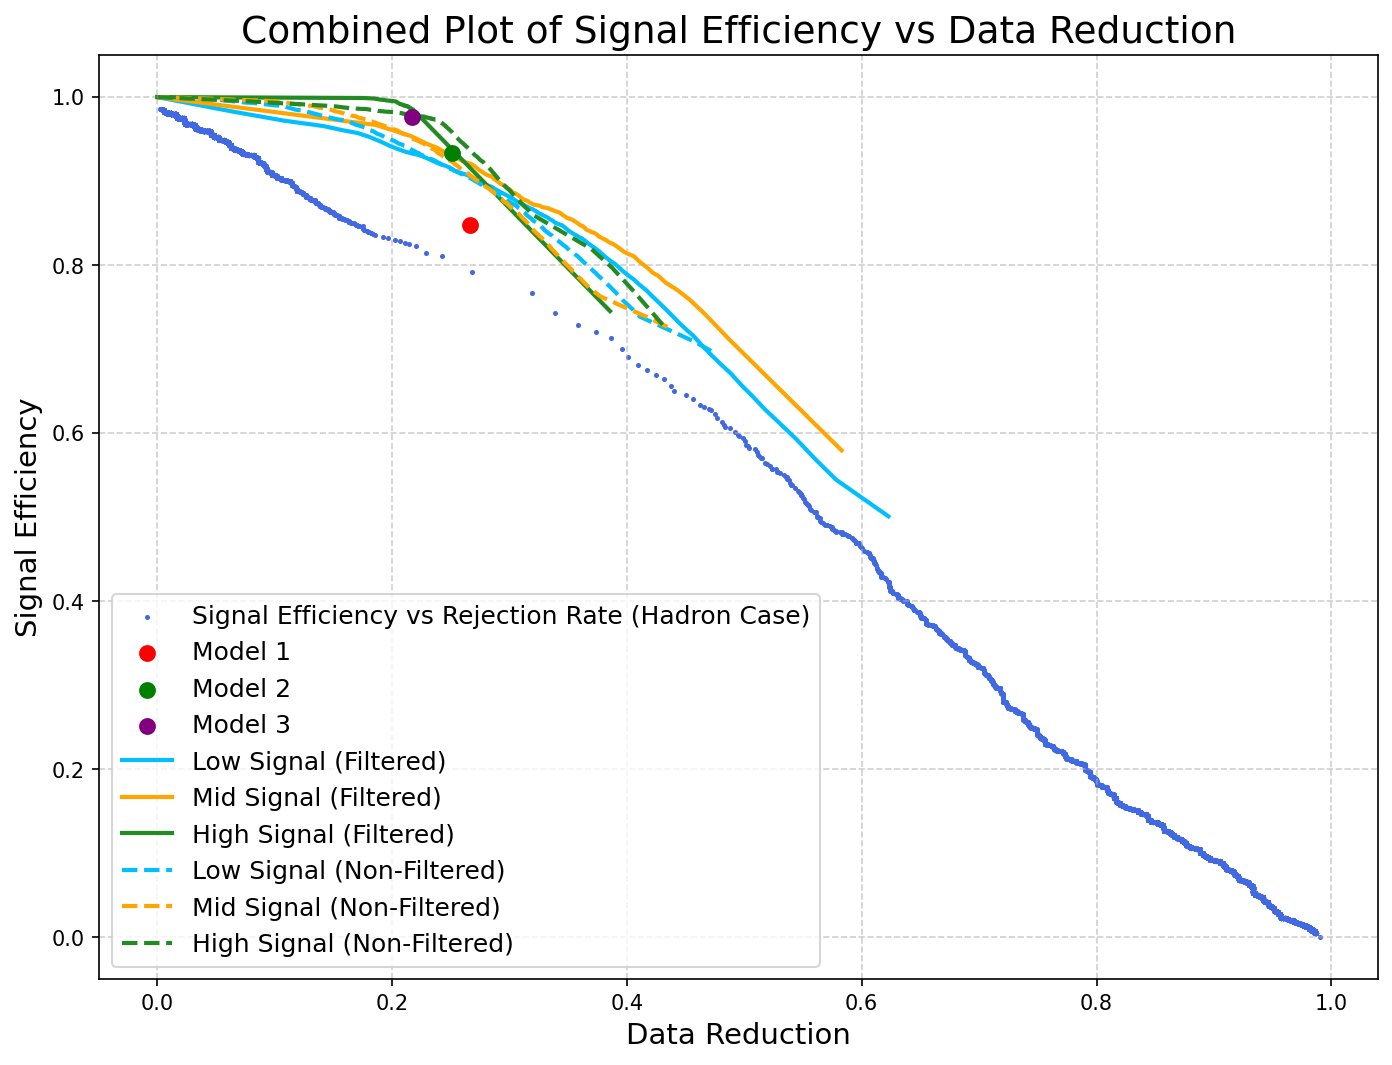

In [31]:
import matplotlib.pyplot as plt

# Create a single figure
plt.figure(figsize=(11, 8))

# Plot data from the first plot
plt.scatter(
    rejection_rate,
    signal_efficiency,
    label="Signal Efficiency vs Rejection Rate (Hadron Case)",
    color="royalblue",
    s=2,
)

# Plot and differentiate points from the table (first plot)
for model, coords in table_points.items():
    plt.scatter(
        coords["bkg_rej"],
        coords["sig_eff"],
        color=coords["color"],
        s=50,
        zorder=5,
        label=model,
    )

# Categories and updated colors for the second plot
categories = ["Low", "Mid", "High"]
colors = ["deepskyblue", "orange", "forestgreen"]  # Brighter, more visible colors
linestyles = {"filtered": "solid", "non-filtered": "dashed"}

# Plot filtered data from the second plot
for category, color in zip(categories, colors):
    plt.plot(
        results_over_a_filtered[category]["reduction"],
        results_over_a_filtered[category]["efficiency"],
        label=f"{category} Signal (Filtered)",
        color=color,
        linestyle=linestyles["filtered"],
        linewidth=2,  # Slightly reduced thickness
    )

# Plot non-filtered data from the second plot
for category, color in zip(categories, colors):
    plt.plot(
        results_over_a_non_filtered[category]["reduction"],
        results_over_a_non_filtered[category]["efficiency"],
        label=f"{category} Signal (Non-Filtered)",
        color=color,
        linestyle=linestyles["non-filtered"],
        linewidth=2,  # Slightly reduced thickness
    )

# Add labels and title
plt.xlabel("Data Reduction", fontsize=14)
plt.ylabel("Signal Efficiency", fontsize=14)
plt.title("Combined Plot of Signal Efficiency vs Data Reduction", fontsize=18)
plt.grid(True, linestyle='--', alpha=0.6)

# Adjust the legend to prevent overlapping
plt.legend(fontsize=12, loc="lower left")

# Display the combined plot
plt.show()
